# Network summaries
* Network statistics. Write to *_network_summary.csv
* Network intersections. Write to *_intersections.csv

In [2]:
import numpy as np
import pandas as pd
import pickle
import sys
import os
import collections
import geneTSmunging as gtm
import network_helpers as nh
import causal_pipeline as cp
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy
from scipy import misc
import matplotlib.image as mpimg

from IPython.display import display, HTML
%matplotlib inline

In [39]:
# SET THESE
run_type = os.getcwd().split(os.sep)[-2]
fdr = 0.05

null = "g"
fdr_type = "l"

# fdr_type = run_type.split("_")[2][0]



run_folder = "run"
run_subfolders = [x for x in os.listdir(run_folder) if not x.startswith(".")]
names = ["_".join([run_subfolder.split("_")[0].split("-")[0],
                   run_subfolder.split("_")[1], run_subfolder.split("_")[4]]) for run_subfolder in run_subfolders]
names = [name.replace("prot2TPM", "orig") for name in names]

namelabels = [cp.run_to_label(name) for name in names]
namelabels = [namelabel.replace("enet-", "").replace("_", "-").upper() for namelabel in namelabels]
nameshortlabels = ["".join([x[0] if x  not in {"ZS", "ZU"} else "S" if "S" in x else "U" for x in namelabel.split("-")]) for namelabel in namelabels]



folders = [os.path.join(run_folder, run_subfolder) for run_subfolder in run_subfolders]
network_folder = "networks/" # only consider the union network, not the individual lags
networkfiles = [os.path.join(network_folder, x) for x in os.listdir(network_folder) if not x.startswith(".")] 

total_data_index = 0

print "index of total data: ", total_data_index
print "Run type: ", run_type
print "Names: ", names
print "Namelabels: ", namelabels
print "Short name labels: ", nameshortlabels
print "Run subfolders:" ,run_subfolders
print "Network files: ", networkfiles

# check that they correspond
if not all([run_subfolder in networkfile for run_subfolder, networkfile in zip(run_subfolders, networkfiles)]):
    raise ValueError("Networks and run folders don't correspond")
    
    
print
print "Run type (same as Mother folder): "
print run_type
print "Null: ", null
print "FDR type: ", fdr_type

index of total data:  0
Run type:  integration
Names:  ['integration_0mean-unnormalized_enet-1', 'orig_0mean-1var_enet-1', 'orig_0mean-1var_enet-2', 'orig_0mean-unnormalized_enet-1', 'orig_0mean-unnormalized_enet-2']
Namelabels:  ['INT-ZU-1', 'ORIG-ZS-1', 'ORIG-ZS-2', 'ORIG-ZU-1', 'ORIG-ZU-2']
Short name labels:  ['IU1', 'OS1', 'OS2', 'OU1', 'OU2']
Run subfolders: ['integration-er-reps_0mean-unnormalized_g-null_l-fdr-0.05_enet-1', 'prot2TPM-er-reps_0mean-1var_g-null_l-fdr-0.05_enet-1', 'prot2TPM-er-reps_0mean-1var_g-null_l-fdr-0.05_enet-2', 'prot2TPM-er-reps_0mean-unnormalized_g-null_l-fdr-0.05_enet-1', 'prot2TPM-er-reps_0mean-unnormalized_g-null_l-fdr-0.05_enet-2']
Network files:  ['networks/integration-er-reps_0mean-unnormalized_g-null_l-fdr-0.05_enet-1-union-network.txt', 'networks/prot2TPM-er-reps_0mean-1var_g-null_l-fdr-0.05_enet-1-union-network.txt', 'networks/prot2TPM-er-reps_0mean-1var_g-null_l-fdr-0.05_enet-2-union-network.txt', 'networks/prot2TPM-er-reps_0mean-unnormalized_g-

In [4]:
# Make directories


base_out_dir = "analysis"
if not os.path.exists(base_out_dir):
    os.makedirs(base_out_dir)

plot_folder = os.path.join(base_out_dir, "plots")
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)



In [5]:
hypers = [pickle.load(open(folder+  os.sep + "hyper" + os.sep + "best_hyper.p", 'rB')) for folder in folders]
networks = [pd.read_csv(netfile, sep="\t") for netfile in networkfiles]
tests = [gtm.load_params(os.path.join(folder, "params.csv"))["CAUSAL"] for folder in folders]
lags = [gtm.load_params(os.path.join(folder, "params.csv"))["LAG"] for folder in folders]
norms = [gtm.load_params(os.path.join(folder, "params.csv"))["NORMALIZATION"] for folder in folders]

genenumlist = []
for folder in folders:
    with open(os.path.join(folder, "data", gtm.load_params(os.path.join(folder, "params.csv"))["GENENAME"]), 'rU') as f:
        genenumlist.append(len(f.readlines()))


# Fit summaries

In [6]:
summary_normfiles = [os.path.join(folder, "fit", "fit_all_summary_normal.txt") for folder in folders]
#summary_randfiles = [folder + os.sep + "fit_all_summary_random.txt" for folder in folders]
summary_fdrfiles = [os.path.join(folder, "fit", "fit_all_summary_" + fdr_type + "-fdr" + ".txt") for folder in folders]

print "FDR summaries"
print summary_fdrfiles

summary_norms = [pd.read_csv(s, sep="\t") for s in summary_normfiles]
#summary_rands = [pd.read_csv(s, sep="\t") for s in summary_randfiles]
summary_fdrs = [pd.read_csv(s, sep="\t") for s in summary_fdrfiles]

FDR summaries
['run/integration-er-reps_0mean-unnormalized_g-null_l-fdr-0.05_enet-1/fit/fit_all_summary_l-fdr.txt', 'run/prot2TPM-er-reps_0mean-1var_g-null_l-fdr-0.05_enet-1/fit/fit_all_summary_l-fdr.txt', 'run/prot2TPM-er-reps_0mean-1var_g-null_l-fdr-0.05_enet-2/fit/fit_all_summary_l-fdr.txt', 'run/prot2TPM-er-reps_0mean-unnormalized_g-null_l-fdr-0.05_enet-1/fit/fit_all_summary_l-fdr.txt', 'run/prot2TPM-er-reps_0mean-unnormalized_g-null_l-fdr-0.05_enet-2/fit/fit_all_summary_l-fdr.txt']


In [7]:
# Show normal summaries

print "Normal summaries"
for name, summary_norm in zip(names, summary_norms):
    print name
    print summary_norm

Normal summaries
integration_0mean-unnormalized_enet-1
                                           Test: enet
0                                              Lag: 1
1   Hyper: (0.10000000000000001, 0.10000000000000001)
2                                     Responses: 2768
3                             Coefs per response:2768
4                                 Total nonzero:37936
5                Nonzero Coefs/Response:13.7052023121
6   Intercept avg: -0.00904038485193std: 0.1152168...
7                                Average fit result: 
8                             DW:Lag1        2.321747
9                             df            13.705202
10                            dual_gap       0.000331
11                            mse            0.022959
12                            n            136.000000
13                            r2             0.515862
14                            row         1383.500000
15                            sse            3.122377
16                         

In [8]:
# Show fdr summaries

print "fdr summaries"
for i, name  in enumerate(names):
    summary_fdr = summary_fdrs[i]
    print name
    
    summary_fdr["Name"] = name
    cols = list(summary_fdr)
    cols.insert(0, cols.pop(cols.index('Name')))
    summary_fdr = summary_fdr.ix[:, cols]
    
    display(summary_fdr)
    

fdr summaries
integration_0mean-unnormalized_enet-1


,Name,Test,Lag,Coef,Hyper,FDR,Causal Genes,Effect Genes,Sig. Edges,% Sig. Edges,Total Genes,Total possible Edges,Threshold_mean,Threshold_std,Matrix,Filename
0,integration_0mean-unnormalized_enet-1,enet,1,1,"(0.10000000000000001, 0.10000000000000001)",0.01,49,1451,2126,0.027748,2768,7661824,0.046,0.03,fdr-0.01-effect/integration-0mean-reps-er-norm...,fdr-0.01-effect/integration-0mean-reps-er-norm...
1,integration_0mean-unnormalized_enet-1,enet,1,1,"(0.10000000000000001, 0.10000000000000001)",0.05,49,1451,2126,0.027748,2768,7661824,0.046,0.03,fdr-0.05-effect/integration-0mean-reps-er-norm...,fdr-0.05-effect/integration-0mean-reps-er-norm...
2,integration_0mean-unnormalized_enet-1,enet,1,1,"(0.10000000000000001, 0.10000000000000001)",0.10,49,1451,2126,0.027748,2768,7661824,0.046,0.03,fdr-0.1-effect/integration-0mean-reps-er-norm-...,fdr-0.1-effect/integration-0mean-reps-er-norm-...
3,integration_0mean-unnormalized_enet-1,enet,1,1,"(0.10000000000000001, 0.10000000000000001)",0.20,49,1451,2127,0.027761,2768,7661824,0.046,0.03,fdr-0.2-effect/integration-0mean-reps-er-norm-...,fdr-0.2-effect/integration-0mean-reps-er-norm-...


orig_0mean-1var_enet-1


,Name,Test,Lag,Coef,Hyper,FDR,Causal Genes,Effect Genes,Sig. Edges,% Sig. Edges,Total Genes,Total possible Edges,Threshold_mean,Threshold_std,Matrix,Filename
0,orig_0mean-1var_enet-1,enet,1,1,"(0.001, 0.10000000000000001)",0.01,758,2195,10530,0.137435,2768,7661824,0.078,0.015,fdr-0.01-effect/prot2TPM-0mean1var-reps-er-nor...,fdr-0.01-effect/prot2TPM-0mean1var-reps-er-nor...
1,orig_0mean-1var_enet-1,enet,1,1,"(0.001, 0.10000000000000001)",0.05,758,2195,10546,0.137643,2768,7661824,0.077,0.015,fdr-0.05-effect/prot2TPM-0mean1var-reps-er-nor...,fdr-0.05-effect/prot2TPM-0mean1var-reps-er-nor...
2,orig_0mean-1var_enet-1,enet,1,1,"(0.001, 0.10000000000000001)",0.10,795,2195,11187,0.146010,2768,7661824,0.077,0.015,fdr-0.1-effect/prot2TPM-0mean1var-reps-er-norm...,fdr-0.1-effect/prot2TPM-0mean1var-reps-er-norm...
3,orig_0mean-1var_enet-1,enet,1,1,"(0.001, 0.10000000000000001)",0.20,997,2195,16584,0.216450,2768,7661824,0.072,0.019,fdr-0.2-effect/prot2TPM-0mean1var-reps-er-norm...,fdr-0.2-effect/prot2TPM-0mean1var-reps-er-norm...


orig_0mean-1var_enet-2


,Name,Test,Lag,Coef,Hyper,FDR,Causal Genes,Effect Genes,Sig. Edges,% Sig. Edges,Total Genes,Total possible Edges,Threshold_mean,Threshold_std,Matrix,Filename
0,orig_0mean-1var_enet-2,enet,2,1,"(0.10000000000000001, 0.10000000000000001)",0.01,692,2195,7434,0.097027,2768,7661824,0.056,0.013,fdr-0.01-effect/prot2TPM-0mean1var-reps-er-nor...,fdr-0.01-effect/prot2TPM-0mean1var-reps-er-nor...
1,orig_0mean-1var_enet-2,enet,2,2,"(0.10000000000000001, 0.10000000000000001)",0.01,576,1975,6485,0.084640,2768,7661824,0.055,0.013,fdr-0.01-effect/prot2TPM-0mean1var-reps-er-nor...,fdr-0.01-effect/prot2TPM-0mean1var-reps-er-nor...
2,orig_0mean-1var_enet-2,enet,2,1,"(0.10000000000000001, 0.10000000000000001)",0.05,692,2195,7434,0.097027,2768,7661824,0.056,0.013,fdr-0.05-effect/prot2TPM-0mean1var-reps-er-nor...,fdr-0.05-effect/prot2TPM-0mean1var-reps-er-nor...
3,orig_0mean-1var_enet-2,enet,2,2,"(0.10000000000000001, 0.10000000000000001)",0.05,576,1975,6485,0.084640,2768,7661824,0.055,0.013,fdr-0.05-effect/prot2TPM-0mean1var-reps-er-nor...,fdr-0.05-effect/prot2TPM-0mean1var-reps-er-nor...
4,orig_0mean-1var_enet-2,enet,2,1,"(0.10000000000000001, 0.10000000000000001)",0.10,704,2195,7532,0.098306,2768,7661824,0.056,0.014,fdr-0.1-effect/prot2TPM-0mean1var-reps-er-norm...,fdr-0.1-effect/prot2TPM-0mean1var-reps-er-norm...
5,orig_0mean-1var_enet-2,enet,2,2,"(0.10000000000000001, 0.10000000000000001)",0.10,582,1975,6546,0.085437,2768,7661824,0.055,0.014,fdr-0.1-effect/prot2TPM-0mean1var-reps-er-norm...,fdr-0.1-effect/prot2TPM-0mean1var-reps-er-norm...
6,orig_0mean-1var_enet-2,enet,2,1,"(0.10000000000000001, 0.10000000000000001)",0.20,814,2195,8981,0.117218,2768,7661824,0.055,0.015,fdr-0.2-effect/prot2TPM-0mean1var-reps-er-norm...,fdr-0.2-effect/prot2TPM-0mean1var-reps-er-norm...
7,orig_0mean-1var_enet-2,enet,2,2,"(0.10000000000000001, 0.10000000000000001)",0.20,634,1975,7596,0.099141,2768,7661824,0.054,0.015,fdr-0.2-effect/prot2TPM-0mean1var-reps-er-norm...,fdr-0.2-effect/prot2TPM-0mean1var-reps-er-norm...


orig_0mean-unnormalized_enet-1


,Name,Test,Lag,Coef,Hyper,FDR,Causal Genes,Effect Genes,Sig. Edges,% Sig. Edges,Total Genes,Total possible Edges,Threshold_mean,Threshold_std,Matrix,Filename
0,orig_0mean-unnormalized_enet-1,enet,1,1,"(0.001, 0.10000000000000001)",0.01,698,2721,22759,0.297044,2768,7661824,0.067,0.028,fdr-0.01-effect/prot2TPM-0mean-reps-er-norm-en...,fdr-0.01-effect/prot2TPM-0mean-reps-er-norm-en...
1,orig_0mean-unnormalized_enet-1,enet,1,1,"(0.001, 0.10000000000000001)",0.05,708,2721,23025,0.300516,2768,7661824,0.067,0.028,fdr-0.05-effect/prot2TPM-0mean-reps-er-norm-en...,fdr-0.05-effect/prot2TPM-0mean-reps-er-norm-en...
2,orig_0mean-unnormalized_enet-1,enet,1,1,"(0.001, 0.10000000000000001)",0.10,795,2721,26972,0.352031,2768,7661824,0.064,0.029,fdr-0.1-effect/prot2TPM-0mean-reps-er-norm-ene...,fdr-0.1-effect/prot2TPM-0mean-reps-er-norm-ene...
3,orig_0mean-unnormalized_enet-1,enet,1,1,"(0.001, 0.10000000000000001)",0.20,1079,2721,49967,0.652155,2768,7661824,0.053,0.030,fdr-0.2-effect/prot2TPM-0mean-reps-er-norm-ene...,fdr-0.2-effect/prot2TPM-0mean-reps-er-norm-ene...


orig_0mean-unnormalized_enet-2


,Name,Test,Lag,Coef,Hyper,FDR,Causal Genes,Effect Genes,Sig. Edges,% Sig. Edges,Total Genes,Total possible Edges,Threshold_mean,Threshold_std,Matrix,Filename
0,orig_0mean-unnormalized_enet-2,enet,2,1,"(0.001, 0.10000000000000001)",0.01,515,2536,14537,0.189733,2768,7661824,0.047,0.021,fdr-0.01-effect/prot2TPM-0mean-reps-er-norm-en...,fdr-0.01-effect/prot2TPM-0mean-reps-er-norm-en...
1,orig_0mean-unnormalized_enet-2,enet,2,2,"(0.001, 0.10000000000000001)",0.01,449,2465,13735,0.179265,2768,7661824,0.052,0.025,fdr-0.01-effect/prot2TPM-0mean-reps-er-norm-en...,fdr-0.01-effect/prot2TPM-0mean-reps-er-norm-en...
2,orig_0mean-unnormalized_enet-2,enet,2,1,"(0.001, 0.10000000000000001)",0.05,516,2536,14549,0.189890,2768,7661824,0.047,0.021,fdr-0.05-effect/prot2TPM-0mean-reps-er-norm-en...,fdr-0.05-effect/prot2TPM-0mean-reps-er-norm-en...
3,orig_0mean-unnormalized_enet-2,enet,2,2,"(0.001, 0.10000000000000001)",0.05,449,2465,13744,0.179383,2768,7661824,0.052,0.025,fdr-0.05-effect/prot2TPM-0mean-reps-er-norm-en...,fdr-0.05-effect/prot2TPM-0mean-reps-er-norm-en...
4,orig_0mean-unnormalized_enet-2,enet,2,1,"(0.001, 0.10000000000000001)",0.10,554,2536,15600,0.203607,2768,7661824,0.047,0.021,fdr-0.1-effect/prot2TPM-0mean-reps-er-norm-ene...,fdr-0.1-effect/prot2TPM-0mean-reps-er-norm-ene...
5,orig_0mean-unnormalized_enet-2,enet,2,2,"(0.001, 0.10000000000000001)",0.10,481,2465,14779,0.192891,2768,7661824,0.051,0.025,fdr-0.1-effect/prot2TPM-0mean-reps-er-norm-ene...,fdr-0.1-effect/prot2TPM-0mean-reps-er-norm-ene...
6,orig_0mean-unnormalized_enet-2,enet,2,1,"(0.001, 0.10000000000000001)",0.20,730,2536,23778,0.310344,2768,7661824,0.041,0.024,fdr-0.2-effect/prot2TPM-0mean-reps-er-norm-ene...,fdr-0.2-effect/prot2TPM-0mean-reps-er-norm-ene...
7,orig_0mean-unnormalized_enet-2,enet,2,2,"(0.001, 0.10000000000000001)",0.20,611,2465,22680,0.296013,2768,7661824,0.046,0.028,fdr-0.2-effect/prot2TPM-0mean-reps-er-norm-ene...,fdr-0.2-effect/prot2TPM-0mean-reps-er-norm-ene...


In [9]:
# displaying the 0.05 networks, for downstream display

summary_fdr_all_by_coef = pd.concat([s[s["FDR"] == fdr] for s in summary_fdrs])


summary_fdr_all_by_coef["Null"] = "local" if null.startswith("l") else 'global' if null.startswith('g') else "ERROR"
summary_fdr_all_by_coef["FDR type"] = "local" if fdr_type == 'l' else 'global' if fdr_type == 'g' else "ERROR"
summary_fdr_all_by_coef["Hyper"] = [cp.hyper_to_label(eval(str(x))) for x in summary_fdr_all_by_coef["Hyper"]]
summary_fdr_all_by_coef["% Sig. Edges"] = [round(x, 2) for x in summary_fdr_all_by_coef["% Sig. Edges"].values]



summary_fdr_all_by_coef_file = os.path.join("analysis", run_type + "_network-run-summary-by-coef.csv")
summary_fdr_all_by_coef[cols].to_csv(summary_fdr_all_by_coef_file,  index=0)
print "Summary written to ", summary_fdr_all_by_coef_file
display(summary_fdr_all_by_coef[["Name", "Test", "Lag", "Coef", "Null", "Hyper", "FDR type", "FDR", "Sig. Edges", "% Sig. Edges", "Total possible Edges",
                         "Causal Genes", "Effect Genes"]])

Summary written to  analysis/integration_network-run-summary-by-coef.csv


,Name,Test,Lag,Coef,Null,Hyper,FDR type,FDR,Sig. Edges,% Sig. Edges,Total possible Edges,Causal Genes,Effect Genes
1,integration_0mean-unnormalized_enet-1,enet,1,1,global,"(1E-01, 1E-01)",local,0.05,2126,0.03,7661824,49,1451
1,orig_0mean-1var_enet-1,enet,1,1,global,"(1E-03, 1E-01)",local,0.05,10546,0.14,7661824,758,2195
2,orig_0mean-1var_enet-2,enet,2,1,global,"(1E-01, 1E-01)",local,0.05,7434,0.10,7661824,692,2195
3,orig_0mean-1var_enet-2,enet,2,2,global,"(1E-01, 1E-01)",local,0.05,6485,0.08,7661824,576,1975
1,orig_0mean-unnormalized_enet-1,enet,1,1,global,"(1E-03, 1E-01)",local,0.05,23025,0.30,7661824,708,2721
2,orig_0mean-unnormalized_enet-2,enet,2,1,global,"(1E-03, 1E-01)",local,0.05,14549,0.19,7661824,516,2536
3,orig_0mean-unnormalized_enet-2,enet,2,2,global,"(1E-03, 1E-01)",local,0.05,13744,0.18,7661824,449,2465


In [10]:
# Name, test, lag, null, hyper, fdr type, fdr, sig edges, % sig edges, causal genes, effect genes

summary_fdr_all = pd.DataFrame({"Network": [x.replace("_", ", ").replace("-unnormalized", "") for x in names]})
summary_fdr_all["Test"] = tests
summary_fdr_all["Lag"] = lags
summary_fdr_all["Normalization"] = ["zero-mean unit-variance" if norm == "0mean1var" else "zero-mean unstandardized" if 
                                    norm == "0mean" else None for norm in norms]
summary_fdr_all["Null"] = "local" if null.startswith("l") else 'global' if null.startswith('g') else "ERROR"
summary_fdr_all["FDR"] = "local" if fdr_type == 'l' else 'global' if fdr_type == 'g' else "ERROR"
summary_fdr_all["Hyper"] = cp.hyperlist_to_labellist(hypers)
#summary_fdr_all["FDR"] = fdr
summary_fdr_all["Sig. Edges"] = [net.shape[0] for net in networks]
summary_fdr_all["Sig. Edges (%)"] = [round(net.shape[0] * 100.0 / (genenum * (genenum - 1) ), 2) for net, genenum in zip(networks, genenumlist)]
summary_fdr_all["Causal Genes"] = [len(np.unique(net["Cause"].values)) for net in networks]
summary_fdr_all["Effect Genes"] = [len(np.unique(net["Effect"].values)) for net in networks]



summary_fdr_all_file = os.path.join("analysis", run_type + "_network-run-summary.csv")
summary_fdr_all.to_csv(summary_fdr_all_file,  index=0)
print "Summary written to ", summary_fdr_all_file

display(summary_fdr_all)

Summary written to  analysis/integration_network-run-summary.csv


,Network,Test,Lag,Normalization,Null,FDR,Hyper,Sig. Edges,Sig. Edges (%),Causal Genes,Effect Genes
0,"integration, 0mean, enet-1",enet,1,zero-mean unstandardized,global,local,"(1E-01, 1E-01)",2126,0.03,49,1451
1,"orig, 0mean-1var, enet-1",enet,1,zero-mean unit-variance,global,local,"(1E-03, 1E-01)",10546,0.14,758,2195
2,"orig, 0mean-1var, enet-2",enet,2,zero-mean unit-variance,global,local,"(1E-01, 1E-01)",13879,0.18,860,2525
3,"orig, 0mean, enet-1",enet,1,zero-mean unstandardized,global,local,"(1E-03, 1E-01)",23025,0.30,708,2721
4,"orig, 0mean, enet-2",enet,2,zero-mean unstandardized,global,local,"(1E-03, 1E-01)",27781,0.36,617,2744


# Get intersections, no removals

In [24]:
# Get number of intersections among different ones

import itertools
import scipy.stats as stats

int_matr = np.zeros((len(networks), len(networks)))
#fisher_matr = np.ones((len(networks), len(networks)))

for index in itertools.product(range(len(networks)), repeat=2):
    int_network1, int_network2 = networks[index[0]], networks[index[1]]
    name1, name2 = names[index[0]], names[index[1]]
    
    print name1, name2
    
    inter = len(np.intersect1d(int_network1["Cause-Effect"].values,
                                                   int_network2["Cause-Effect"].values))
    
    int_matr[index[0]][index[1]] =  inter
    print int_matr[index[0]][index[1]]
    
    # Total possible edges: (genes) * (genes - 1), since self-edges ignored
    #%time _, fisher_matr[index[0]][index[1]] = stats.fisher_exact([[inter, int_network1.shape[0] - inter], [int_network2.shape[0] - inter, len(genes) * len(genes) - len(genes) - int_network1.shape[0] - int_network2.shape[0] + inter]])
    
   

integration_0mean-unnormalized_enet-1 integration_0mean-unnormalized_enet-1
2126.0
integration_0mean-unnormalized_enet-1 orig_0mean-1var_enet-1
1.0
integration_0mean-unnormalized_enet-1 orig_0mean-1var_enet-2
0.0
integration_0mean-unnormalized_enet-1 orig_0mean-unnormalized_enet-1
57.0
integration_0mean-unnormalized_enet-1 orig_0mean-unnormalized_enet-2
107.0
orig_0mean-1var_enet-1 integration_0mean-unnormalized_enet-1
1.0
orig_0mean-1var_enet-1 orig_0mean-1var_enet-1
10546.0
orig_0mean-1var_enet-1 orig_0mean-1var_enet-2
2598.0
orig_0mean-1var_enet-1 orig_0mean-unnormalized_enet-1
1563.0
orig_0mean-1var_enet-1 orig_0mean-unnormalized_enet-2
784.0
orig_0mean-1var_enet-2 integration_0mean-unnormalized_enet-1
0.0
orig_0mean-1var_enet-2 orig_0mean-1var_enet-1
2598.0
orig_0mean-1var_enet-2 orig_0mean-1var_enet-2
13879.0
orig_0mean-1var_enet-2 orig_0mean-unnormalized_enet-1
987.0
orig_0mean-1var_enet-2 orig_0mean-unnormalized_enet-2
2075.0
orig_0mean-unnormalized_enet-1 integration_0mean-unn

In [25]:
int_df = pd.DataFrame(int_matr, columns=names, index=names)

int_df_filename = os.path.join(base_out_dir, run_type +  "_network-intersections.csv")

print "Writing to ", int_df_filename

int_df.to_csv(int_df_filename)

display(int_df)

Writing to  analysis/integration_network-intersections.csv


,integration_0mean-unnormalized_enet-1,orig_0mean-1var_enet-1,orig_0mean-1var_enet-2,orig_0mean-unnormalized_enet-1,orig_0mean-unnormalized_enet-2
integration_0mean-unnormalized_enet-1,2126.0,1.0,0.0,57.0,107.0
orig_0mean-1var_enet-1,1.0,10546.0,2598.0,1563.0,784.0
orig_0mean-1var_enet-2,0.0,2598.0,13879.0,987.0,2075.0
orig_0mean-unnormalized_enet-1,57.0,1563.0,987.0,23025.0,6203.0
orig_0mean-unnormalized_enet-2,107.0,784.0,2075.0,6203.0,27781.0


Plot saved to  analysis/plots/integration_log10intersections.pdf


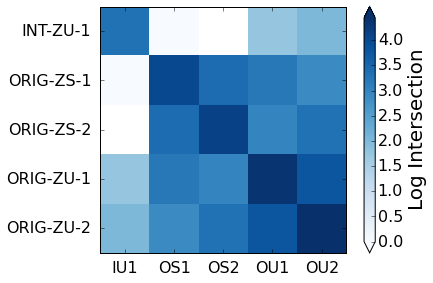

In [26]:
reload(cp)
log10intplot_filename = os.path.join(base_out_dir, "plots", run_type + "_log10intersections.pdf")


cp.plot_corr_matrix(np.log10(int_matr), nameshortlabels, ylabels=namelabels, title="", xlabel="", ylabel="",
                   max_thresh=np.log10(int_matr).max(),
                   filename=log10intplot_filename,
                   figsize=( 1 + int_matr.shape[1], int_matr.shape[0] -1), rotate_x=False, colorbar_label="Log Intersection",
                    xticksize=16, yticksize=16, colorbar_ticksize=16,
                   colorbar_labelsize=20,
                   change_x_pad=True, x_pad=8, change_y_pad=True, y_pad=10)

In [27]:
odds_matr = np.zeros((len(networks), len(networks))) # odds ratio

print "Using total possible edges from the index of the total data network"

for index in itertools.product(range(len(networks)), repeat=2):
    
    
    net1 = int_matr[index[0]][index[0]]
    net2 = int_matr[index[1]][index[1]]

    name1, name2 = names[index[0]], names[index[1]]

    print name1, name2

    total = genenumlist[total_data_index] * (genenumlist[total_data_index]  - 1)

    inter = int_matr[index[0]][index[1]] 

    odds1 = inter * 1.0 / (net1 - inter)
    odds2 = (net2 - inter) * 1.0 / (total - net1 - net2 + inter)

    odds_matr[index[0]][index[1]] = odds1 / odds2

    print odds_matr[index[0]][index[1]]
  

Using total possible edges from the index of the total data network
integration_0mean-unnormalized_enet-1 integration_0mean-unnormalized_enet-1


NameError: name 'total_data_index' is not defined

In [ ]:
odds_df = pd.DataFrame(odds_matr, columns=names, index=names)

odds_df_filename = os.path.join(base_out_dir, run_type +  "_network-odds-ratio.csv")

print "Writing to ", odds_df_filename

odds_df.to_csv(odds_df_filename)

display(odds_df)

In [ ]:
reload(cp) 


oddsplot_filename = os.path.join(base_out_dir, "plots", run_type + "_network-log10odds-ratio.pdf")

plot_matr = np.log10(odds_matr)
max_thresh = plot_matr[np.logical_not(np.isinf(plot_matr))].max()
min_thresh = plot_matr[np.logical_not(np.isinf(plot_matr))].min()

plot_matr[plot_matr == np.Inf] = max_thresh + 1
plot_matr[plot_matr == np.NINF] = min_thresh - 1

cp.plot_corr_matrix(plot_matr, nameshortlabels, ylabels=namelabels, title="", xlabel="", ylabel="",
                    cmap=copy.deepcopy(plt.cm.Greens),
                    filename=oddsplot_filename, max_thresh=max_thresh,
                   min_thresh=min(0, min_thresh),
                    figsize=( 1 + int_matr.shape[1], int_matr.shape[0] - 1), rotate_x=False,
                    colorbar_label="Log Odds Ratio",
                    xticksize=16, yticksize=16, colorbar_ticksize=16,
                   colorbar_labelsize=20, change_x_pad=True, x_pad=8, change_y_pad=True, y_pad=10)

# Get intersections, with removals


## Remove genes that are the Effect

In [33]:
# filter the networks beforehand.
int_networks = networks[:]

# SET THIS!!!!!!!!!!!!!!
remove_genes_list = [[str(nh.hg2ensg(x)) for x in ["CEBPB", "CEBPD", "FOSL2", "FOXO1", "FOXO3", "KLF6",
                     "KLF9", "KLF15", "POU5F1", "TFCP2L1"]]]  + [[]] * (len(int_networks) - 1)

for i in range(len(int_networks)):
    int_network = int_networks[i]
    int_network = int_network[np.logical_not(int_network["Effect"].isin(remove_genes_list[i]))]
    int_networks[i] = int_network
    
    print "*****************"
    print names[i]
    print 
    print "# effect genes to remove: ", len(remove_genes_list[i])
    print "# edges removed: ", networks[i].shape[0] - int_networks[i].shape[0]

*****************
integration_0mean-unnormalized_enet-1

# effect genes to remove:  10
# edges removed:  8
*****************
orig_0mean-1var_enet-1

# effect genes to remove:  0
# edges removed:  0
*****************
orig_0mean-1var_enet-2

# effect genes to remove:  0
# edges removed:  0
*****************
orig_0mean-unnormalized_enet-1

# effect genes to remove:  0
# edges removed:  0
*****************
orig_0mean-unnormalized_enet-2

# effect genes to remove:  0
# edges removed:  0


In [34]:
# Get number of intersections among different ones

import itertools
import scipy.stats as stats

int_matr = np.zeros((len(int_networks), len(int_networks)))
#fisher_matr = np.ones((len(int_networks), len(int_networks)))

for index in itertools.product(range(len(int_networks)), repeat=2):
    int_network1, int_network2 = int_networks[index[0]], int_networks[index[1]]
    name1, name2 = names[index[0]], names[index[1]]
    
    print name1, name2
    
    inter = len(np.intersect1d(int_network1["Cause-Effect"].values,
                                                   int_network2["Cause-Effect"].values))
    
    int_matr[index[0]][index[1]] =  inter
    print int_matr[index[0]][index[1]]
    
    # Total possible edges: (genes) * (genes - 1), since self-edges ignored
    #%time _, fisher_matr[index[0]][index[1]] = stats.fisher_exact([[inter, int_network1.shape[0] - inter], [int_network2.shape[0] - inter, len(genes) * len(genes) - len(genes) - int_network1.shape[0] - int_network2.shape[0] + inter]])
    
   

integration_0mean-unnormalized_enet-1 integration_0mean-unnormalized_enet-1
2118.0
integration_0mean-unnormalized_enet-1 orig_0mean-1var_enet-1
1.0
integration_0mean-unnormalized_enet-1 orig_0mean-1var_enet-2
0.0
integration_0mean-unnormalized_enet-1 orig_0mean-unnormalized_enet-1
57.0
integration_0mean-unnormalized_enet-1 orig_0mean-unnormalized_enet-2
107.0
orig_0mean-1var_enet-1 integration_0mean-unnormalized_enet-1
1.0
orig_0mean-1var_enet-1 orig_0mean-1var_enet-1
10546.0
orig_0mean-1var_enet-1 orig_0mean-1var_enet-2
2598.0
orig_0mean-1var_enet-1 orig_0mean-unnormalized_enet-1
1563.0
orig_0mean-1var_enet-1 orig_0mean-unnormalized_enet-2
784.0
orig_0mean-1var_enet-2 integration_0mean-unnormalized_enet-1
0.0
orig_0mean-1var_enet-2 orig_0mean-1var_enet-1
2598.0
orig_0mean-1var_enet-2 orig_0mean-1var_enet-2
13879.0
orig_0mean-1var_enet-2 orig_0mean-unnormalized_enet-1
987.0
orig_0mean-1var_enet-2 orig_0mean-unnormalized_enet-2
2075.0
orig_0mean-unnormalized_enet-1 integration_0mean-unn

In [35]:
int_df = pd.DataFrame(int_matr, columns=names, index=names)

int_df_filename = os.path.join(base_out_dir, run_type +  "_network-intersections-with-removals.csv")

print "Writing to ", int_df_filename

int_df.to_csv(int_df_filename)

display(int_df)

Writing to  analysis/integration_network-intersections-with-removals.csv


,integration_0mean-unnormalized_enet-1,orig_0mean-1var_enet-1,orig_0mean-1var_enet-2,orig_0mean-unnormalized_enet-1,orig_0mean-unnormalized_enet-2
integration_0mean-unnormalized_enet-1,2118.0,1.0,0.0,57.0,107.0
orig_0mean-1var_enet-1,1.0,10546.0,2598.0,1563.0,784.0
orig_0mean-1var_enet-2,0.0,2598.0,13879.0,987.0,2075.0
orig_0mean-unnormalized_enet-1,57.0,1563.0,987.0,23025.0,6203.0
orig_0mean-unnormalized_enet-2,107.0,784.0,2075.0,6203.0,27781.0


Plot saved to  analysis/plots/integration_log10intersections-with-removals.pdf


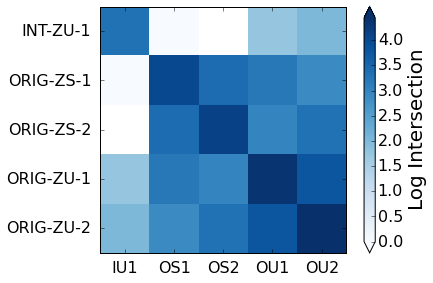

In [36]:
reload(cp)
log10intplot_filename = os.path.join(base_out_dir, "plots", run_type + "_log10intersections-with-removals.pdf")


cp.plot_corr_matrix(np.log10(int_matr), nameshortlabels, ylabels=namelabels, title="", xlabel="", ylabel="",
                   max_thresh=np.log10(int_matr).max(),
                   filename=log10intplot_filename,
                   figsize=( 1 + int_matr.shape[1], int_matr.shape[0] -1), rotate_x=False, colorbar_label="Log Intersection",
                    xticksize=16, yticksize=16, colorbar_ticksize=16,
                   colorbar_labelsize=20,
                   change_x_pad=True, x_pad=8, change_y_pad=True, y_pad=10)

In [40]:
odds_matr = np.zeros((len(int_networks), len(int_networks))) # odds ratio

print "Using total possible edges from the index of the total data network"

for index in itertools.product(range(len(int_networks)), repeat=2):
    
    
    net1 = int_matr[index[0]][index[0]]
    net2 = int_matr[index[1]][index[1]]

    name1, name2 = names[index[0]], names[index[1]]

    print name1, name2

    total = genenumlist[total_data_index] * (genenumlist[total_data_index]  - 1)

    inter = int_matr[index[0]][index[1]] 

    odds1 = inter * 1.0 / (net1 - inter)
    odds2 = (net2 - inter) * 1.0 / (total - net1 - net2 + inter)

    odds_matr[index[0]][index[1]] = odds1 / odds2

    print odds_matr[index[0]][index[1]]
  

Using total possible edges from the index of the total data network
integration_0mean-unnormalized_enet-1 integration_0mean-unnormalized_enet-1
inf
integration_0mean-unnormalized_enet-1 orig_0mean-1var_enet-1
0.342522553879
integration_0mean-unnormalized_enet-1 orig_0mean-1var_enet-2
0.0
integration_0mean-unnormalized_enet-1 orig_0mean-unnormalized_enet-1
9.19229881001
integration_0mean-unnormalized_enet-1 orig_0mean-unnormalized_enet-2
14.6683888322
orig_0mean-1var_enet-1 integration_0mean-unnormalized_enet-1
0.342522553879
orig_0mean-1var_enet-1 orig_0mean-1var_enet-1
inf
orig_0mean-1var_enet-1 orig_0mean-1var_enet-2
221.293930248
orig_0mean-1var_enet-1 orig_0mean-unnormalized_enet-1
61.8335053467
orig_0mean-1var_enet-1 orig_0mean-unnormalized_enet-2
22.6726846512
orig_0mean-1var_enet-2 integration_0mean-unnormalized_enet-1
0.0
orig_0mean-1var_enet-2 orig_0mean-1var_enet-1
221.293930248
orig_0mean-1var_enet-2 orig_0mean-1var_enet-2
inf
orig_0mean-1var_enet-2 orig_0mean-unnormalized_e

In [41]:
odds_df = pd.DataFrame(odds_matr, columns=names, index=names)

odds_df_filename = os.path.join(base_out_dir, run_type +  "_network-odds-ratio-with-removals.csv")

print "Writing to ", odds_df_filename

odds_df.to_csv(odds_df_filename)

display(odds_df)

Writing to  analysis/integration_network-odds-ratio-with-removals.csv


,integration_0mean-unnormalized_enet-1,orig_0mean-1var_enet-1,orig_0mean-1var_enet-2,orig_0mean-unnormalized_enet-1,orig_0mean-unnormalized_enet-2
integration_0mean-unnormalized_enet-1,inf,0.342523,0.000000,9.192299,14.668389
orig_0mean-1var_enet-1,0.342523,inf,221.293930,61.833505,22.672685
orig_0mean-1var_enet-2,0.000000,221.293930,inf,26.482472,52.104978
orig_0mean-unnormalized_enet-1,9.192299,61.833505,26.482472,inf,130.122283
orig_0mean-unnormalized_enet-2,14.668389,22.672685,52.104978,130.122283,inf


Plot saved to  analysis/plots/integration_network-log10odds-ratio-with-removals.pdf


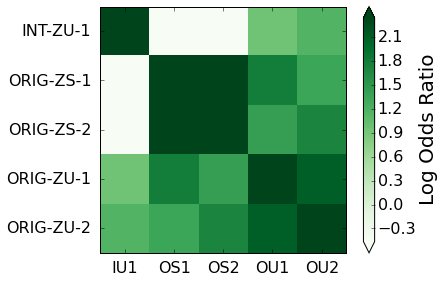

In [42]:
reload(cp) 


oddsplot_filename = os.path.join(base_out_dir, "plots", run_type + "_network-log10odds-ratio-with-removals.pdf")

plot_matr = np.log10(odds_matr)
max_thresh = plot_matr[np.logical_not(np.isinf(plot_matr))].max()
min_thresh = plot_matr[np.logical_not(np.isinf(plot_matr))].min()

plot_matr[plot_matr == np.Inf] = max_thresh + 1
plot_matr[plot_matr == np.NINF] = min_thresh - 1

cp.plot_corr_matrix(plot_matr, nameshortlabels, ylabels=namelabels, title="", xlabel="", ylabel="",
                    cmap=copy.deepcopy(plt.cm.Greens),
                    filename=oddsplot_filename, max_thresh=max_thresh,
                   min_thresh=min(0, min_thresh),
                    figsize=( 1 + int_matr.shape[1], int_matr.shape[0] - 1), rotate_x=False,
                    colorbar_label="Log Odds Ratio",
                    xticksize=16, yticksize=16, colorbar_ticksize=16,
                   colorbar_labelsize=20, change_x_pad=True, x_pad=8, change_y_pad=True, y_pad=10)

# Hyperparameter comparisons

In [27]:
hypermseplotfiles = [folder + os.sep + "plots" + os.sep + "hyper" + os.sep + "hyperVSmse.png" for folder in folders]
hypermseplots = [mpimg.imread(h) for h in hypermseplotfiles]

hyperdffiles = [folder + os.sep + "hyper" + os.sep + "hyper_df.txt" for folder in folders]
hyperdfs = [pd.read_csv(hyperdffile, sep="\t") for hyperdffile in hyperdffiles]
besthyperdfs = [hyperdf.loc[0, :] for hyperdf in hyperdfs]

hypermsecorrplotfiles = [folder + os.sep + "plots" + os.sep + "hyper" + os.sep + "mse_corr.png" for folder in folders]
hypermsecorrplots = [mpimg.imread(h) for h in hypermsecorrplotfiles]

hyperr2plotfiles = [folder + os.sep + "plots" + os.sep + "hyper" + os.sep + "hyperVSr2.png" for folder in folders]
hyperr2plots = [mpimg.imread(h) for h in hyperr2plotfiles]

hyperr2corrplotfiles = [folder + os.sep + "plots" + os.sep + "hyper" + os.sep + "r2_corr.png" for folder in folders]
hyperr2corrplots = [mpimg.imread(h) for h in hyperr2corrplotfiles]

hyperdofplotfiles = [folder + os.sep + "plots" + os.sep + "hyper" + os.sep + "hyperVSdof.png" for folder in folders]
hyperdofplots = [mpimg.imread(h) for h in hyperdofplotfiles]

Hyperparameters VS mse corr
0mean-1var_enet-1
(0.001, 0.10000000000000001)


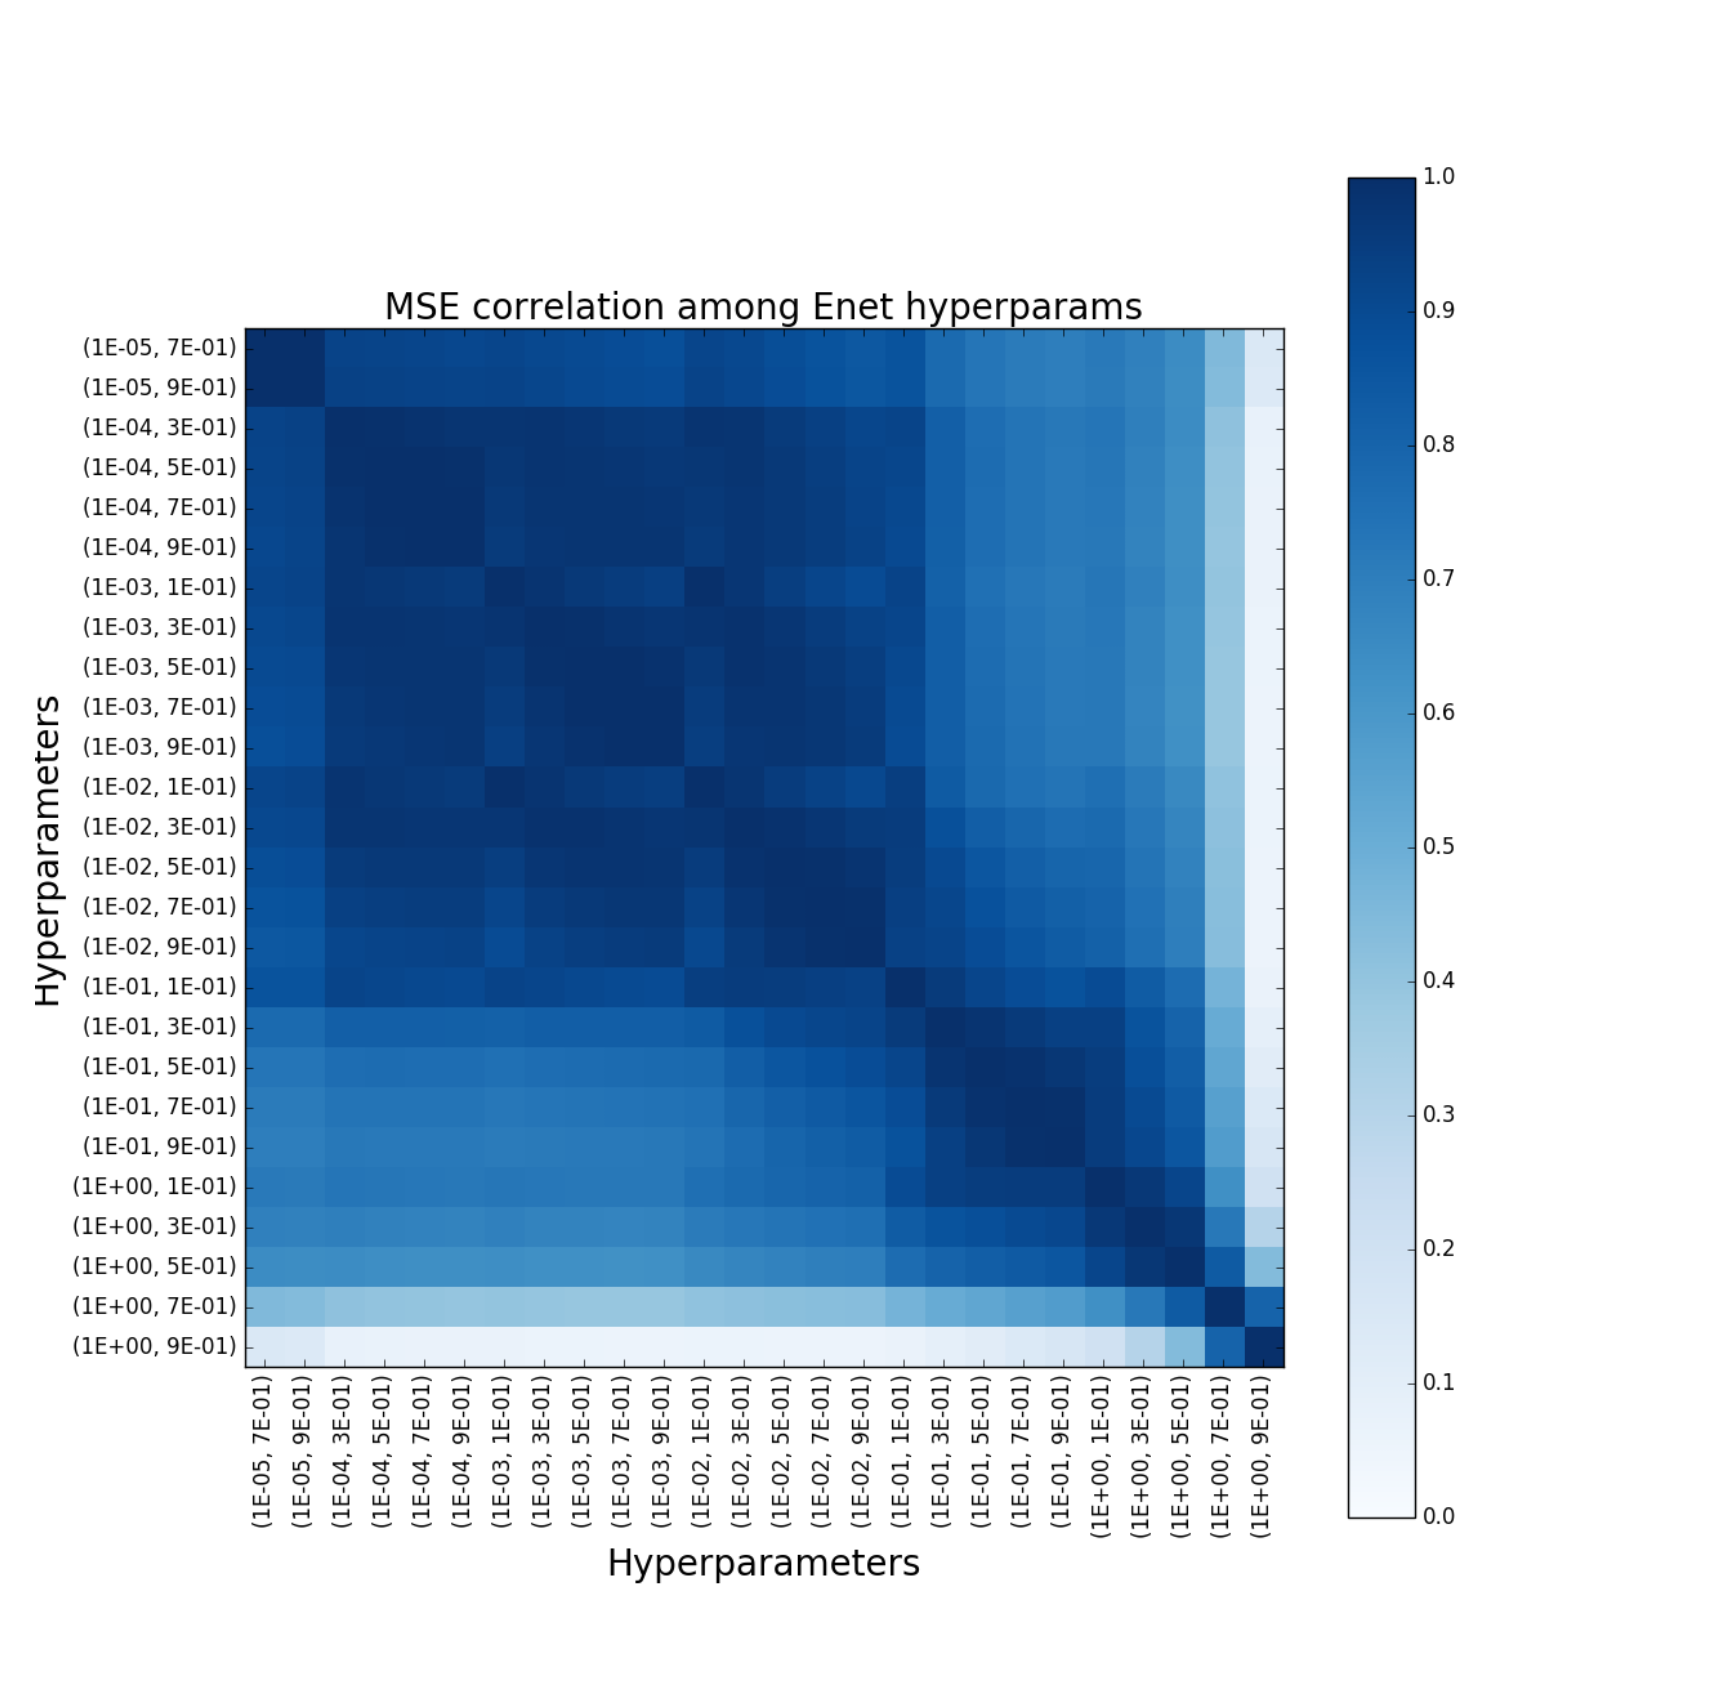

0mean-1var_enet-2
(0.10000000000000001, 0.10000000000000001)


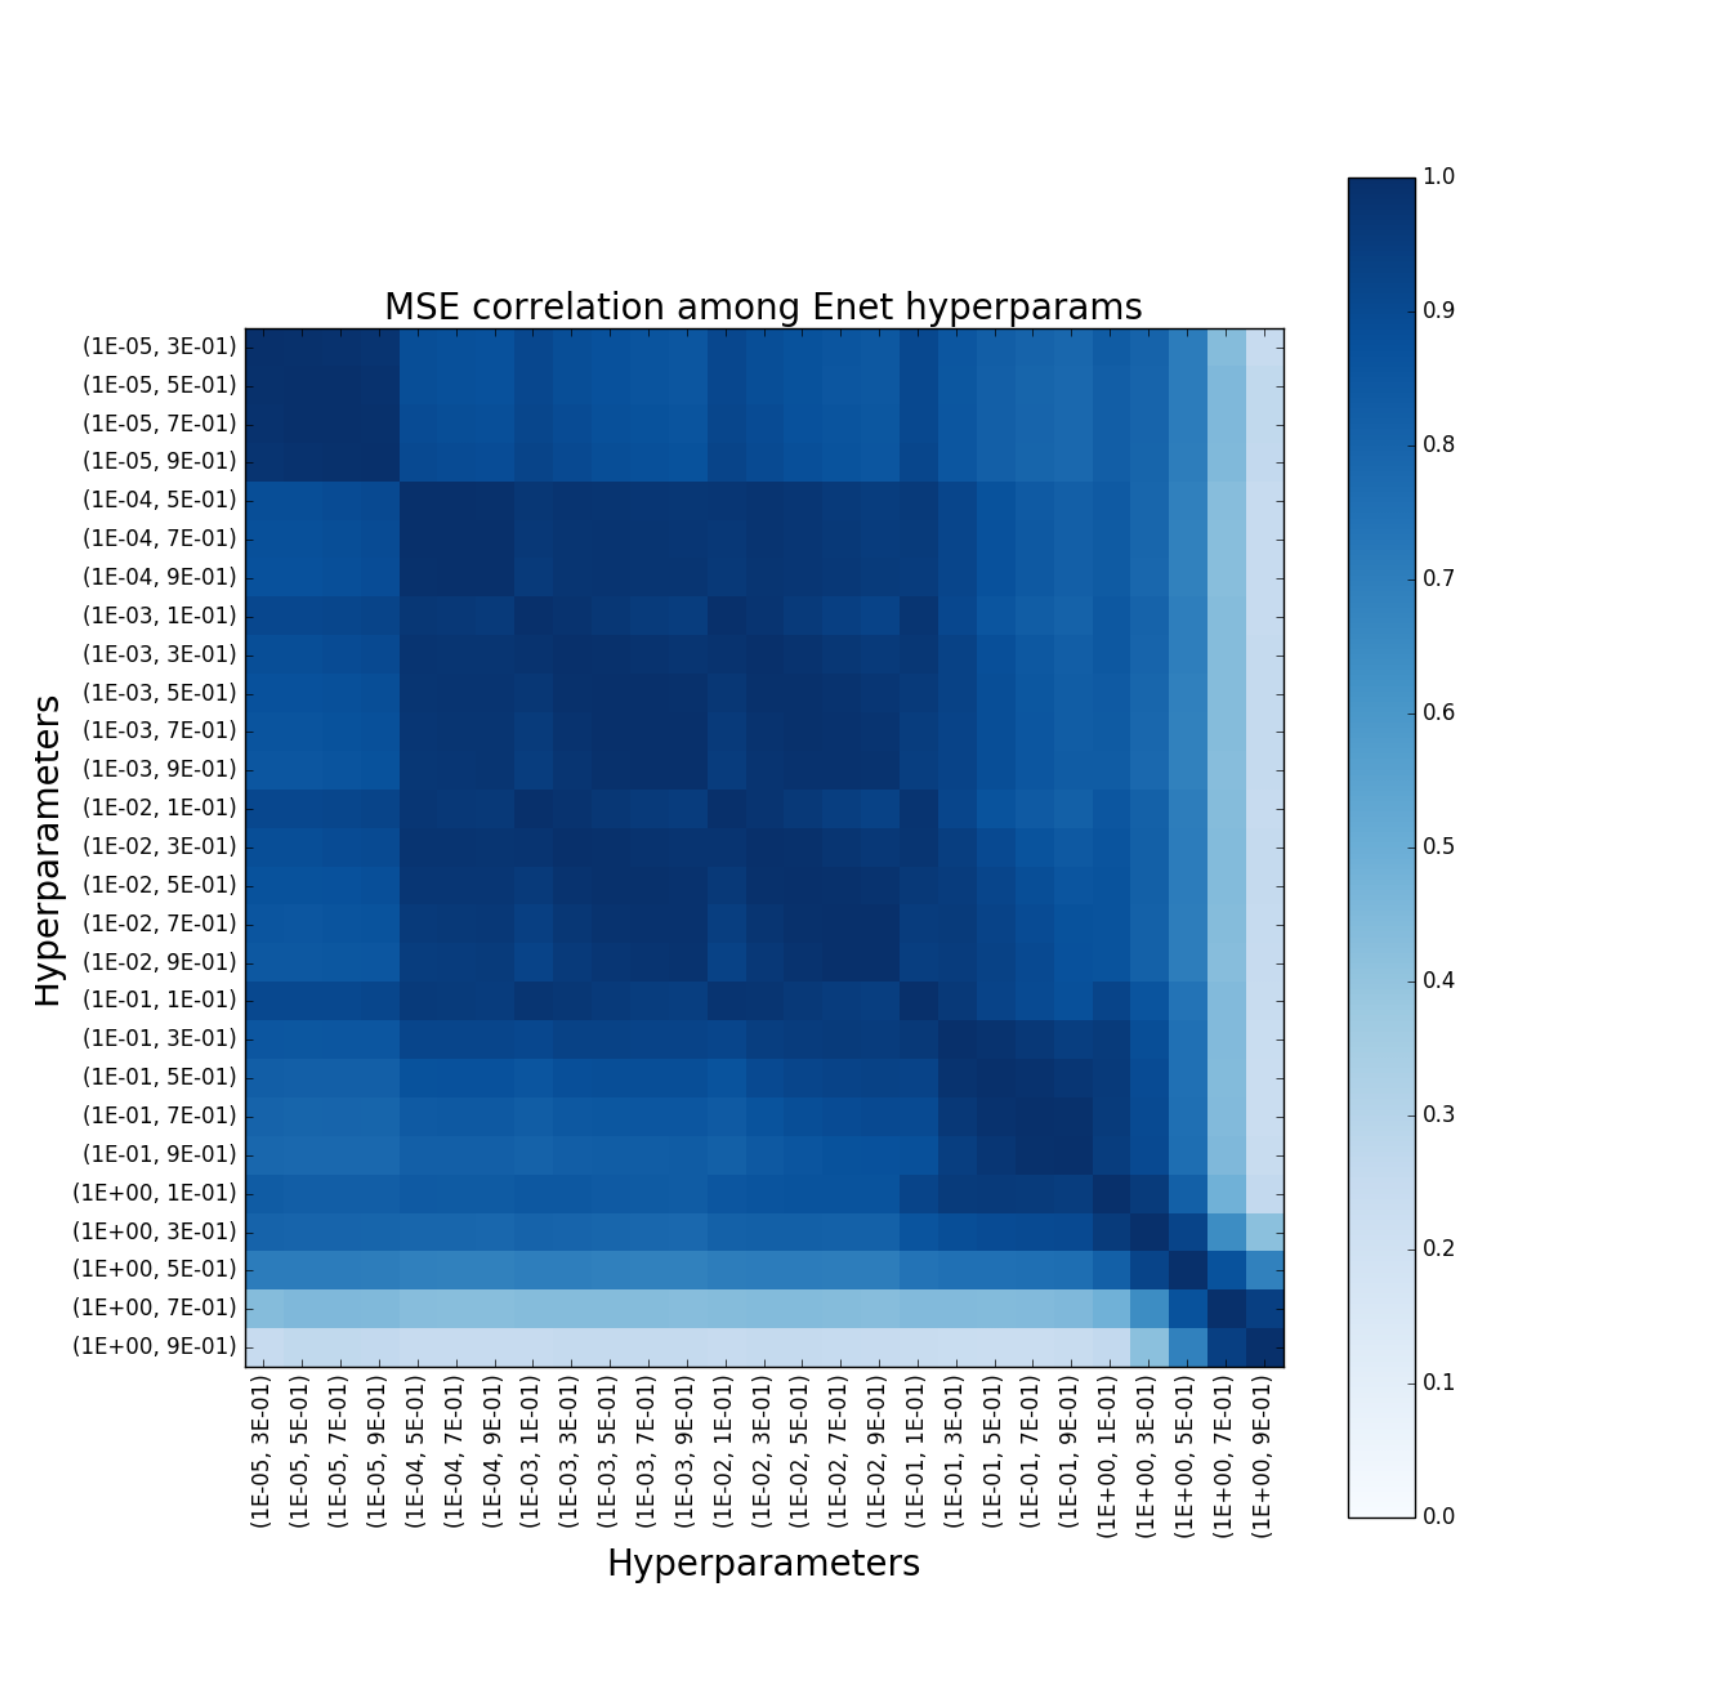

0mean-unnormalized_enet-1
(0.001, 0.10000000000000001)


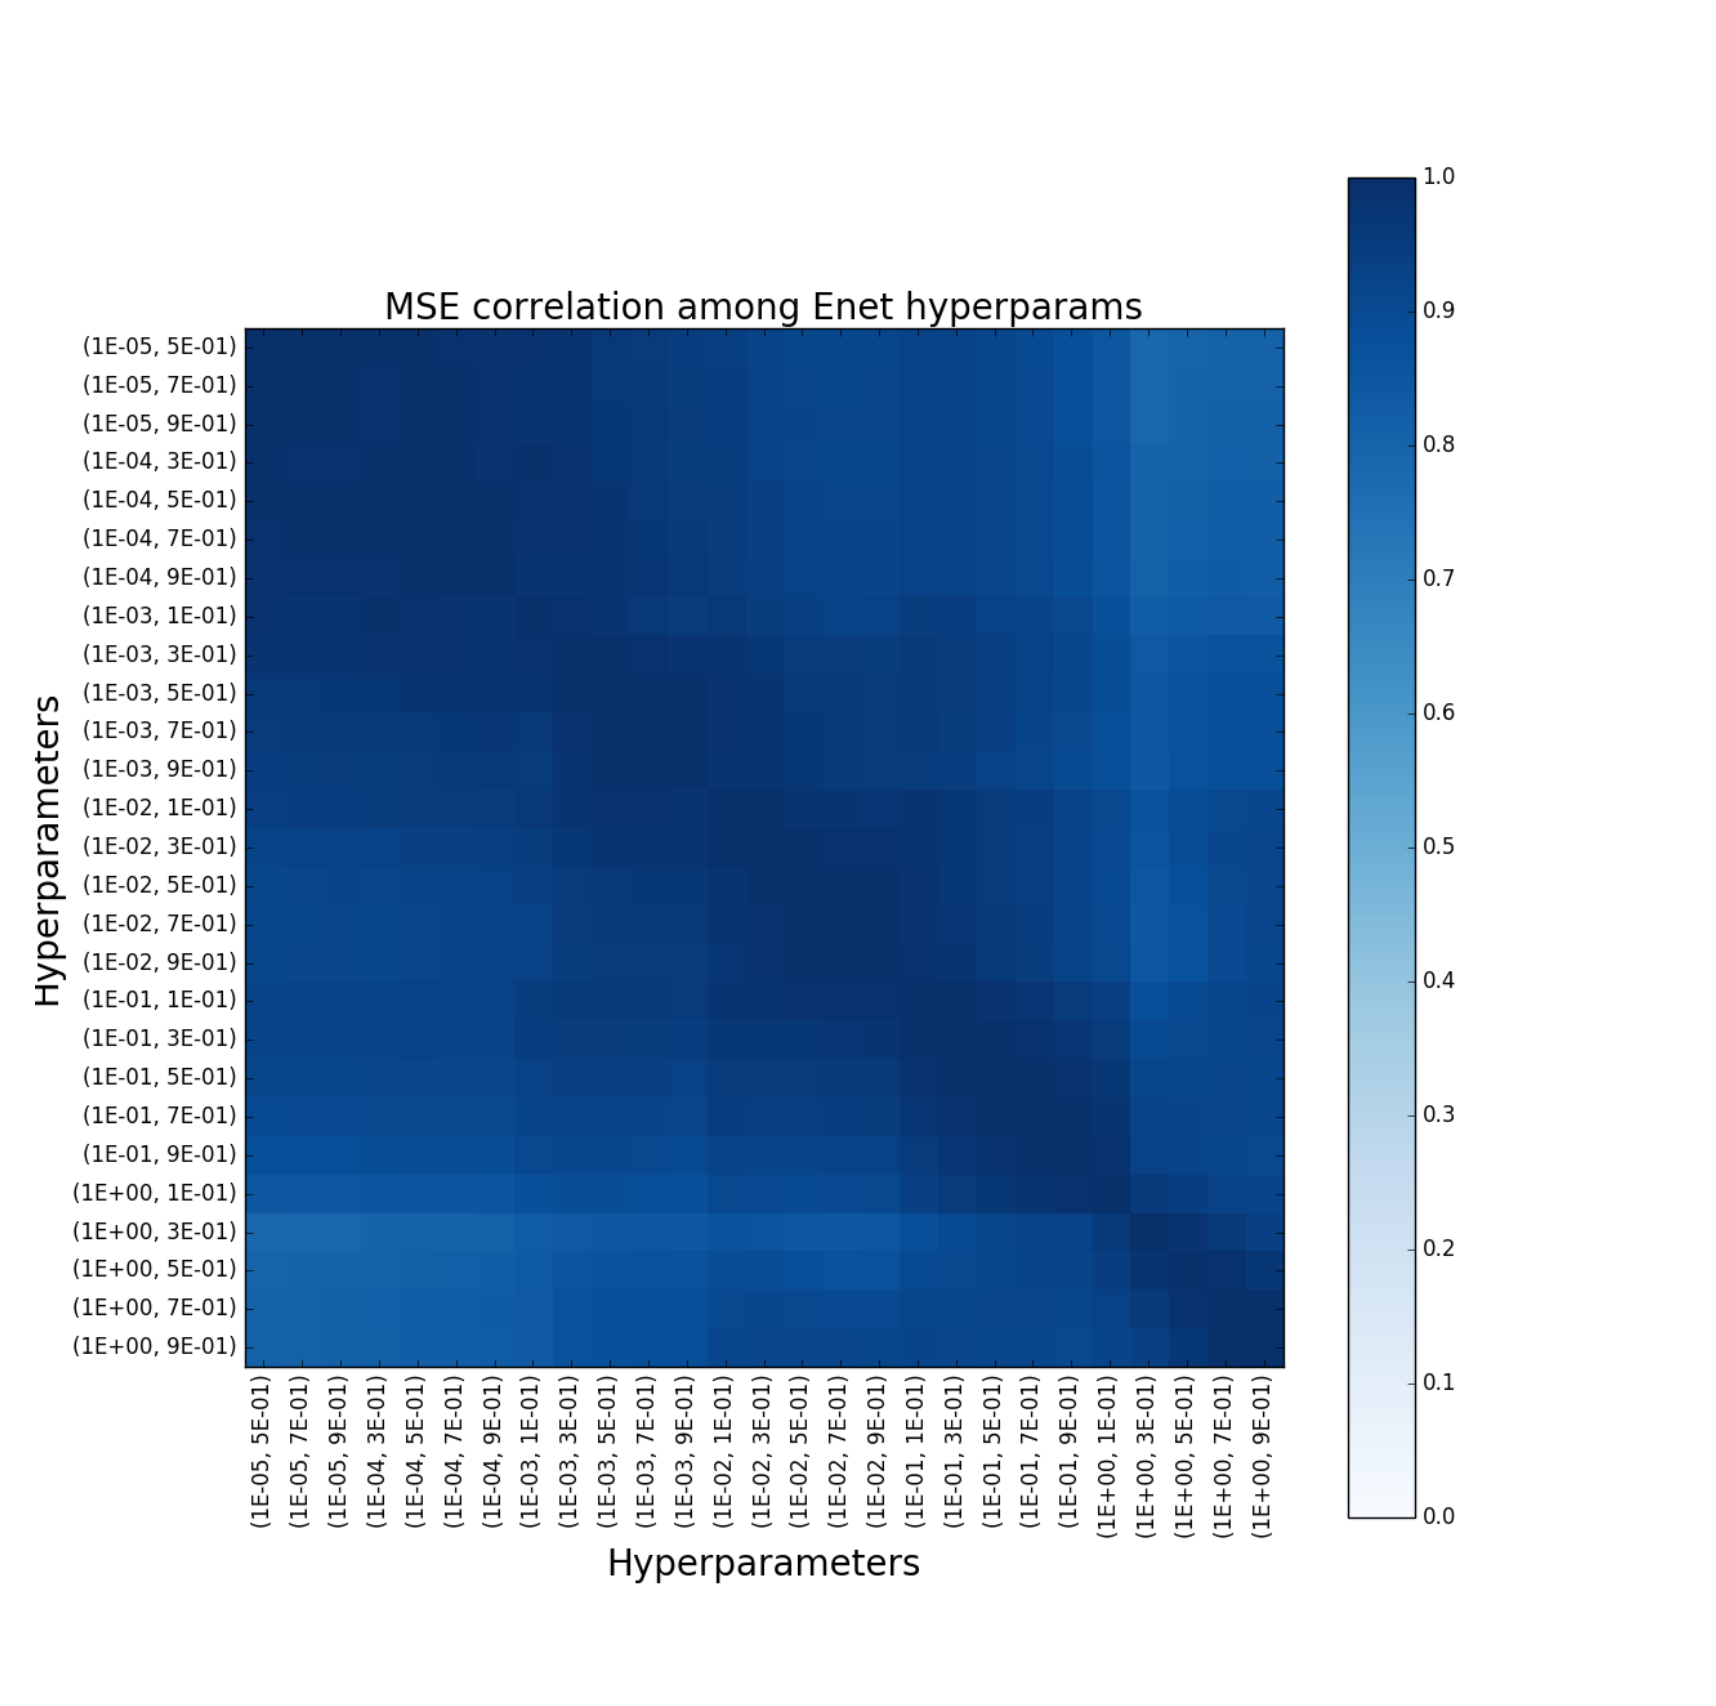

0mean-unnormalized_enet-2
(0.001, 0.10000000000000001)


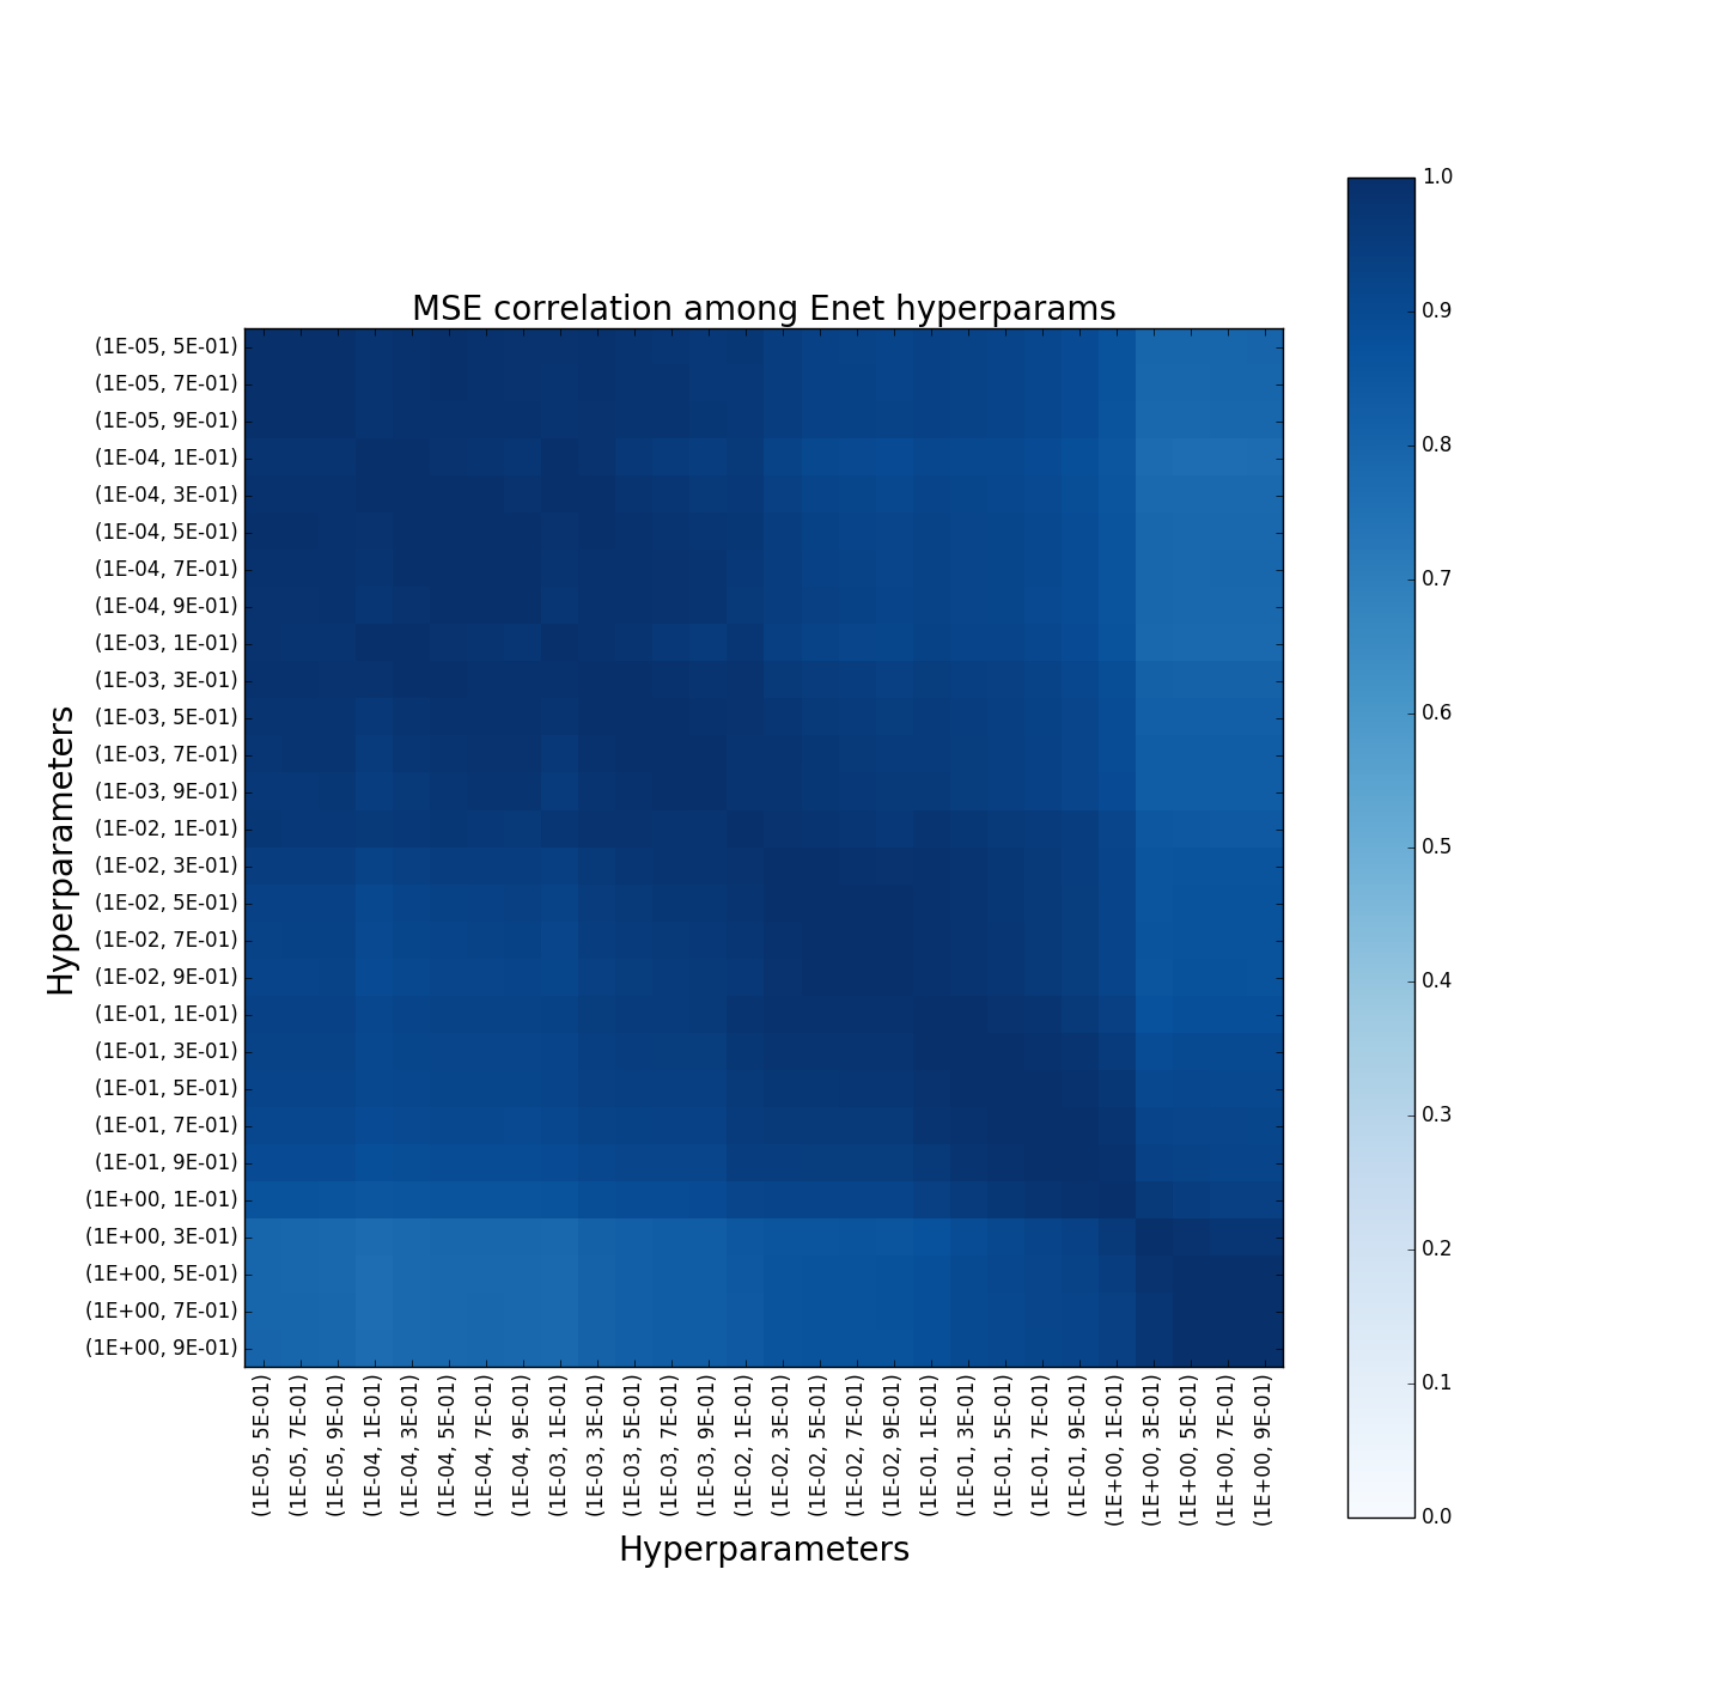

In [11]:
# Plot mse corr. matrix of hypers

print "Hyperparameters VS mse corr"

for name, hypermsecorrplot, hyper in zip(names, hypermsecorrplots, hypers):
    print name
    
    print hyper
    
    if "enet" in name:
        figsize = (40,30)
    else:
        figsize = (10,10)
    
    plt.figure(figsize=figsize)
    plt.imshow(hypermsecorrplot)
    plt.axis('off')
    plt.show()
    

Hyperparameters VS r2
0mean-1var_enet-1


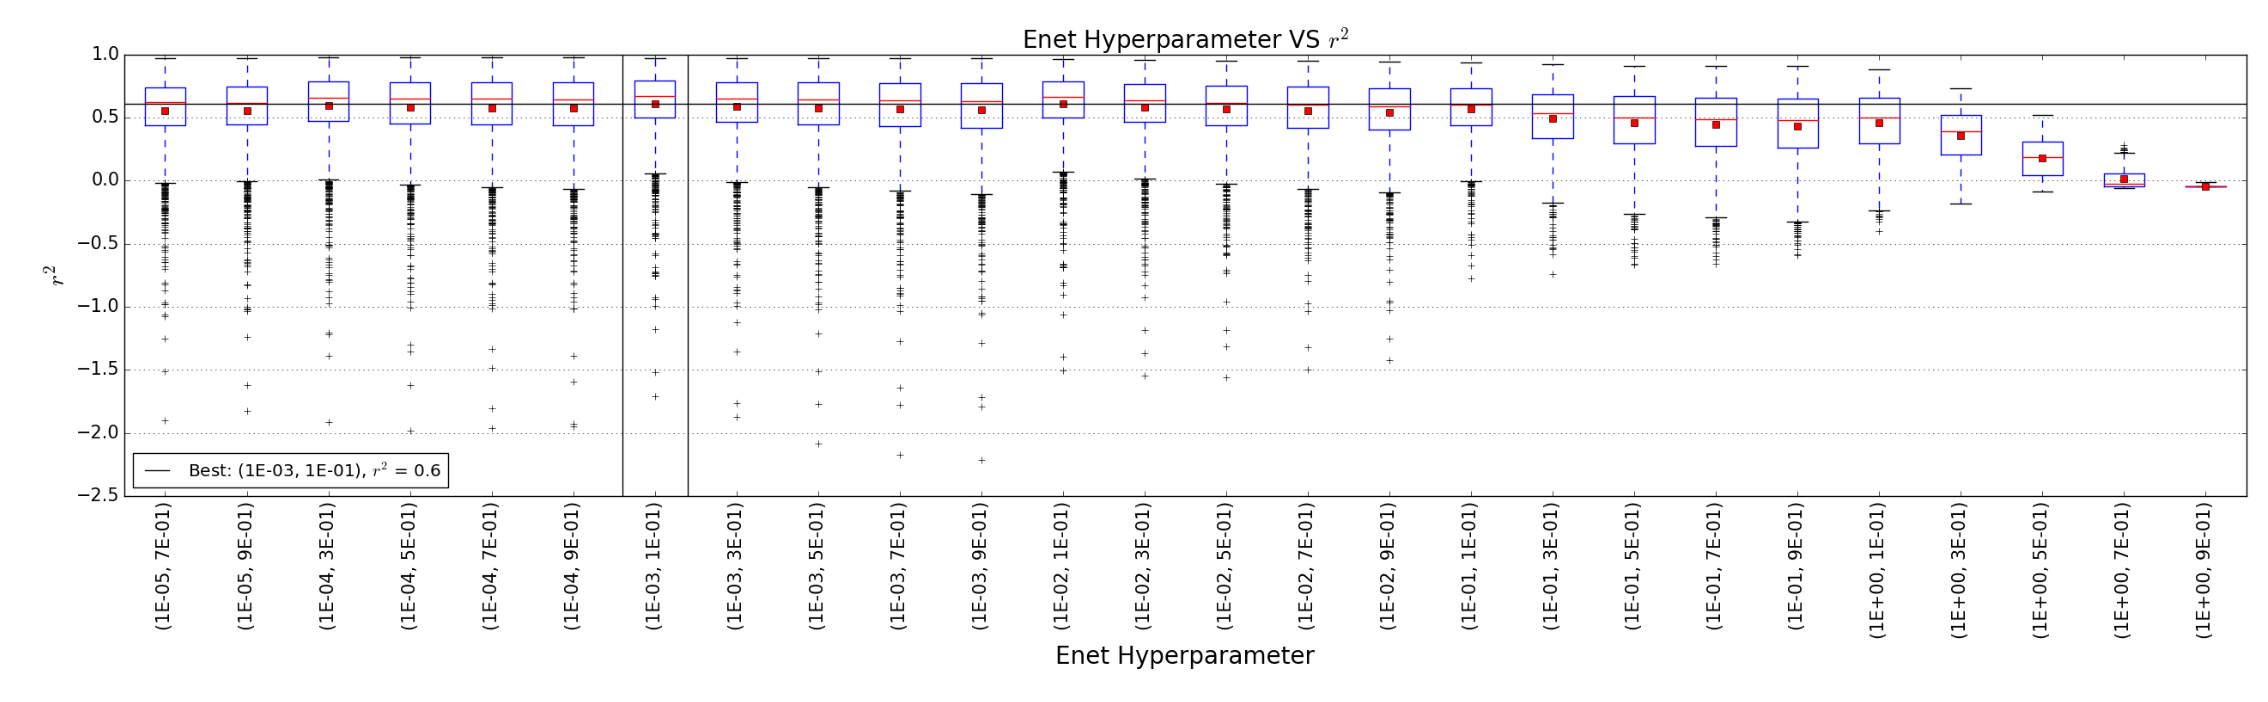

0mean-1var_enet-2


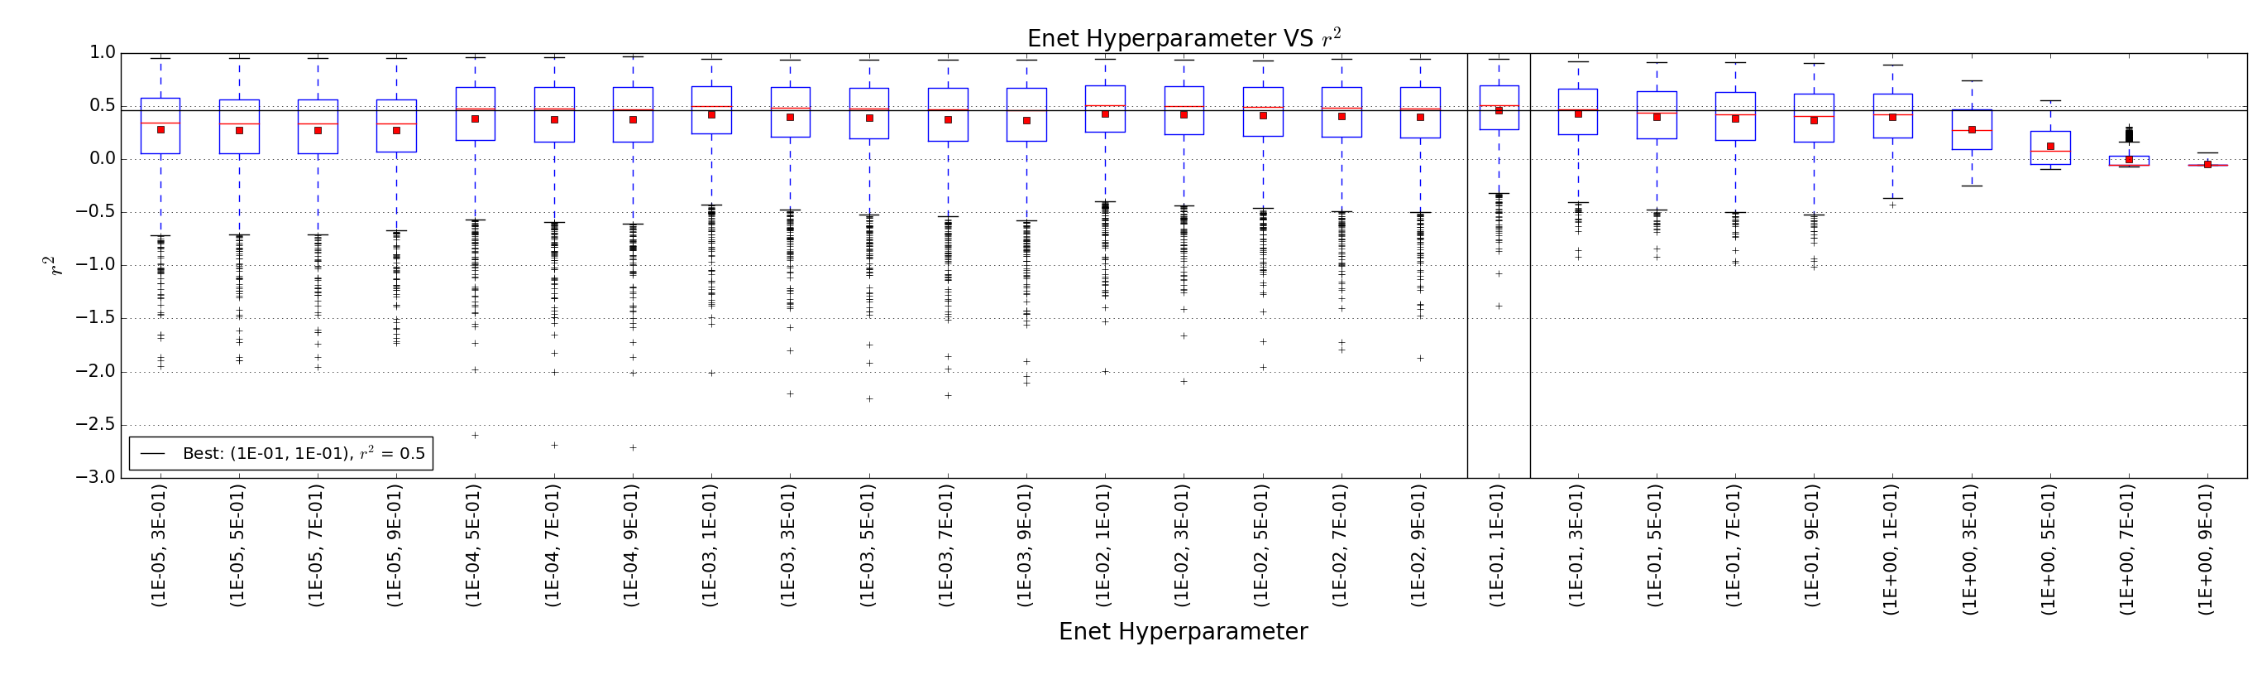

0mean-unnormalized_enet-1


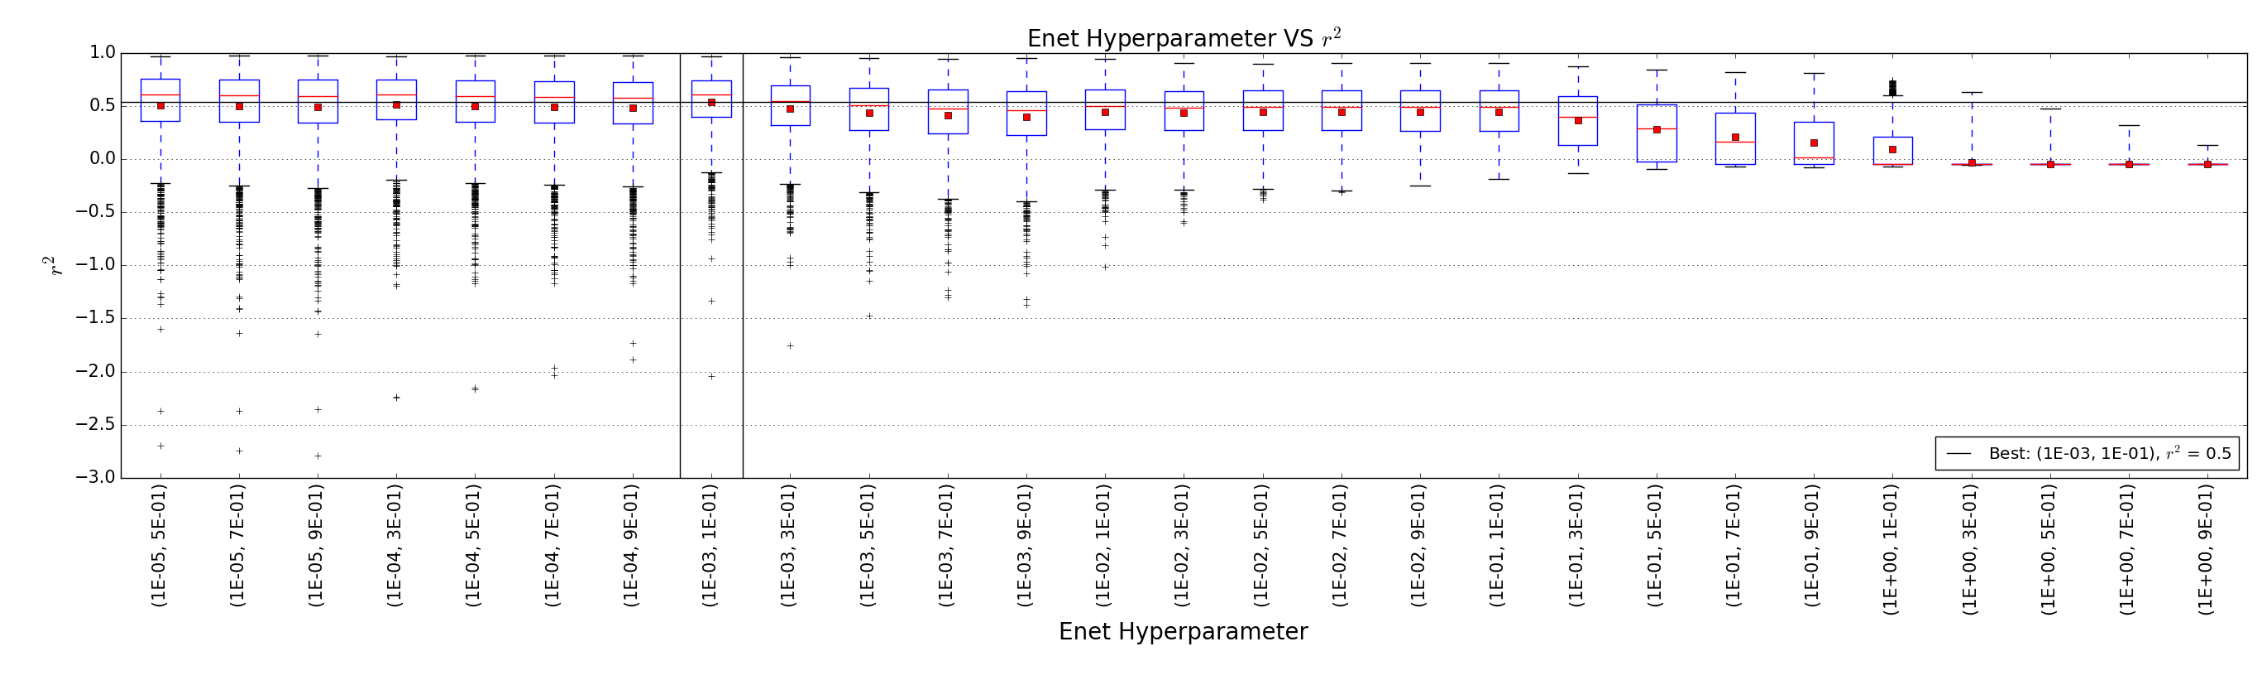

0mean-unnormalized_enet-2


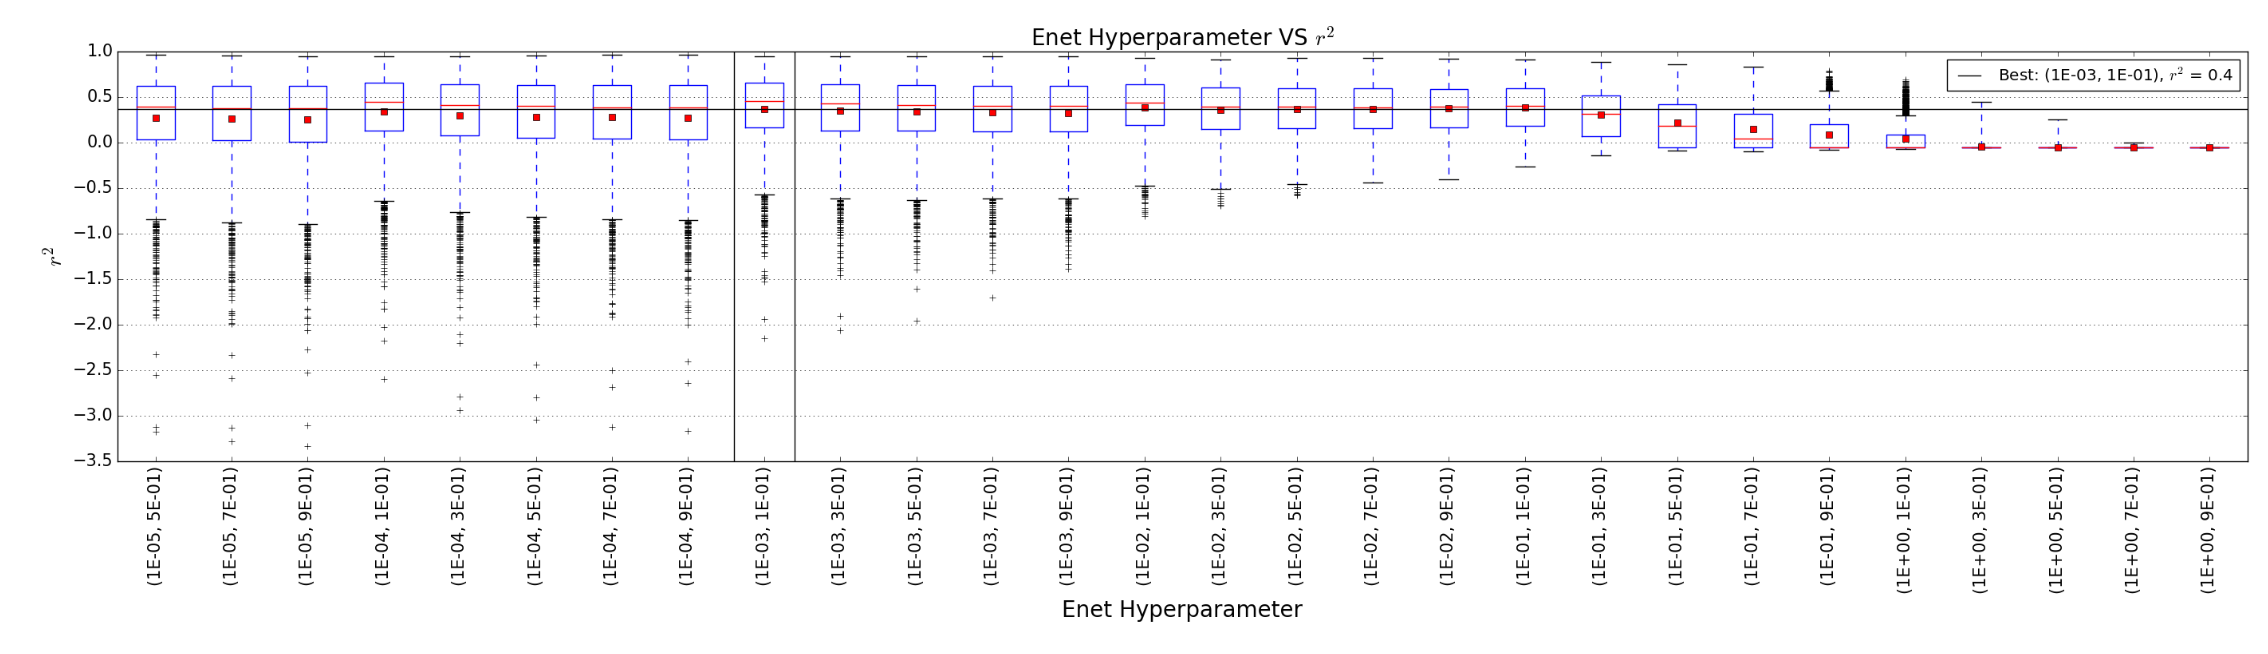

In [12]:
# Plot the hyper VS r2

print "Hyperparameters VS r2"

for name, hyperr2plot in zip(names, hyperr2plots):
    print name
    
    if "enet" in name:
        figsize = (40,30)
    else:
        figsize = (10,10)
    
    plt.figure(figsize=figsize)
    plt.imshow(hyperr2plot)
    plt.axis('off')
    plt.show()
    

Hyperparameters VS dof
0mean-1var_enet-1


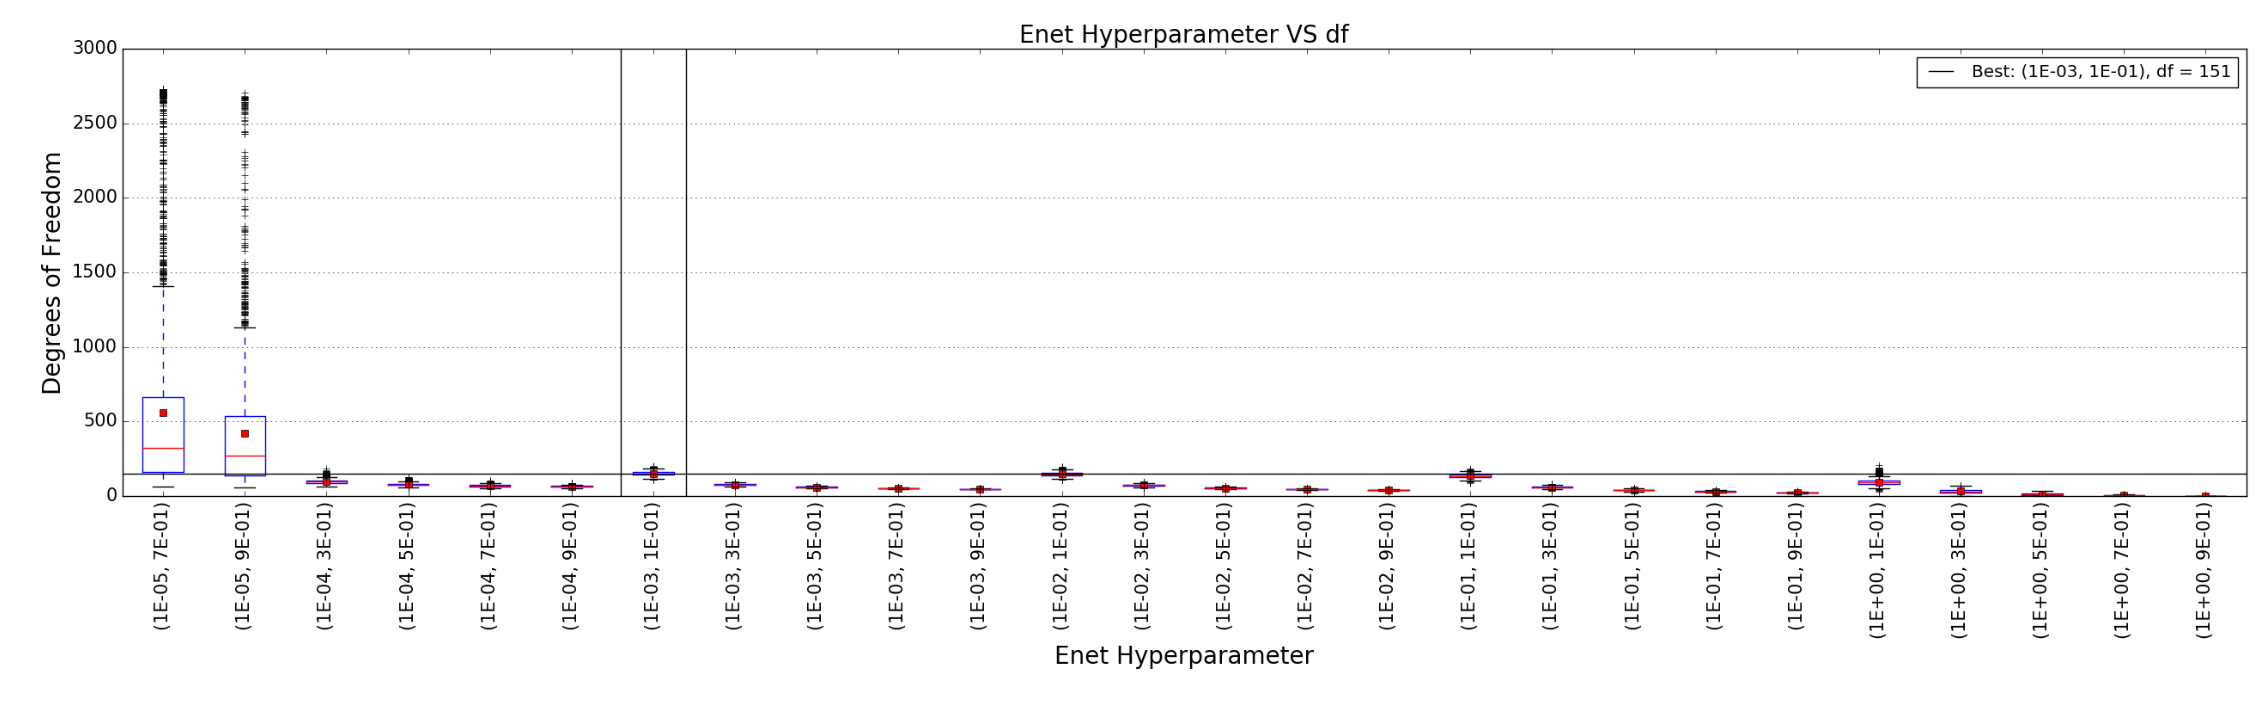

0mean-1var_enet-2


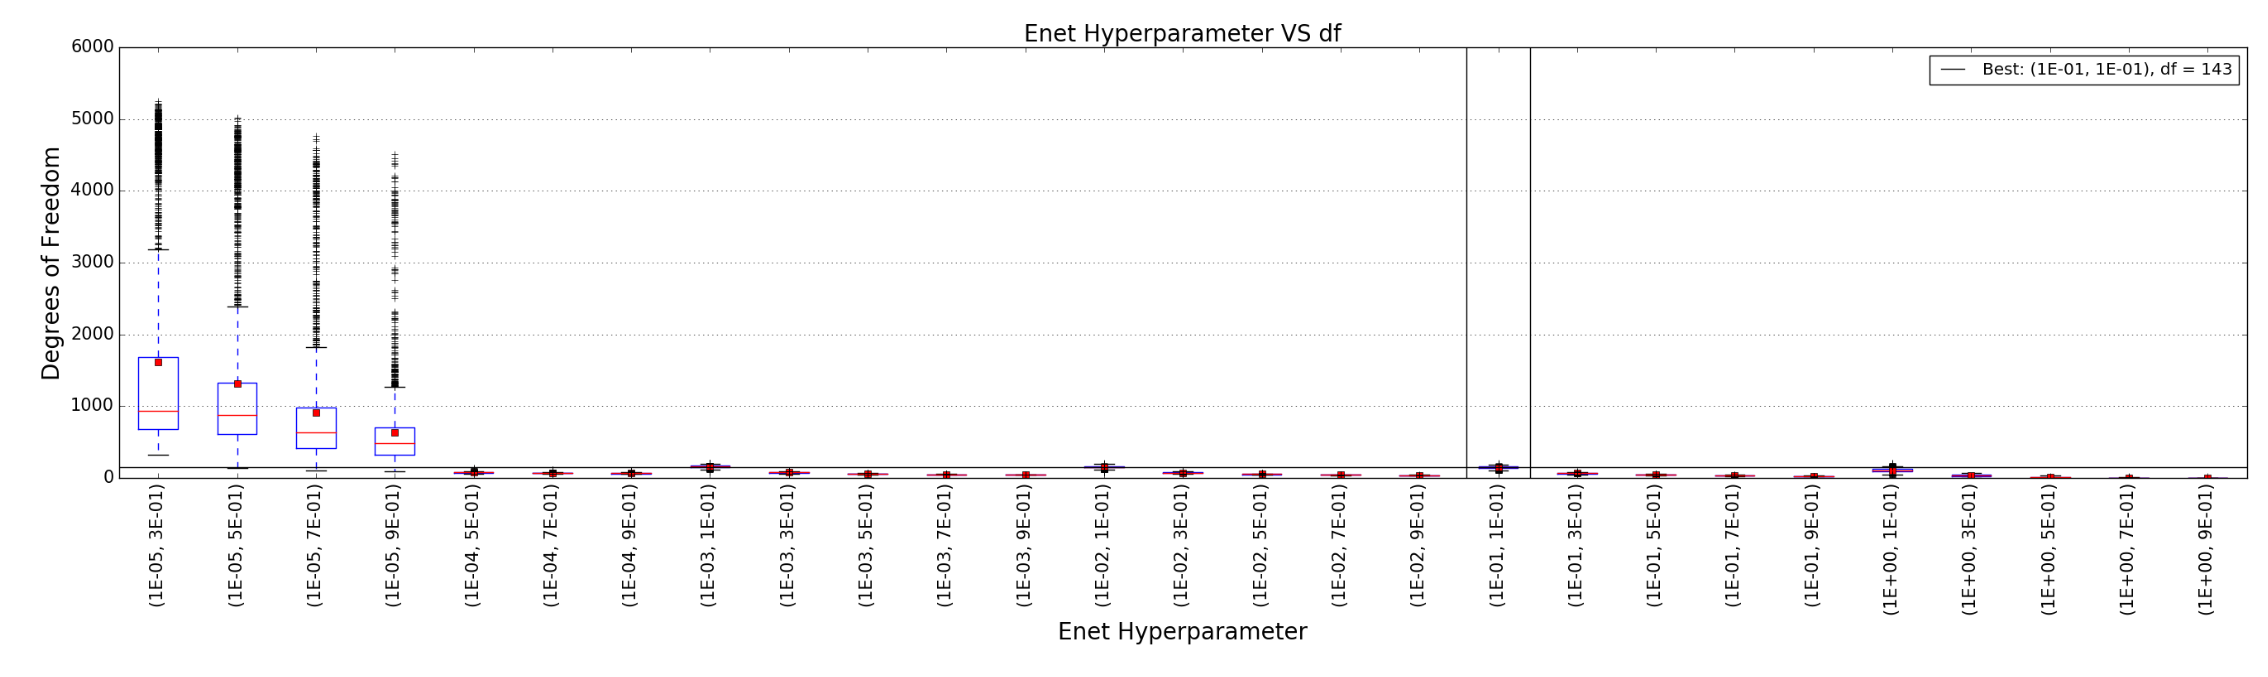

0mean-unnormalized_enet-1


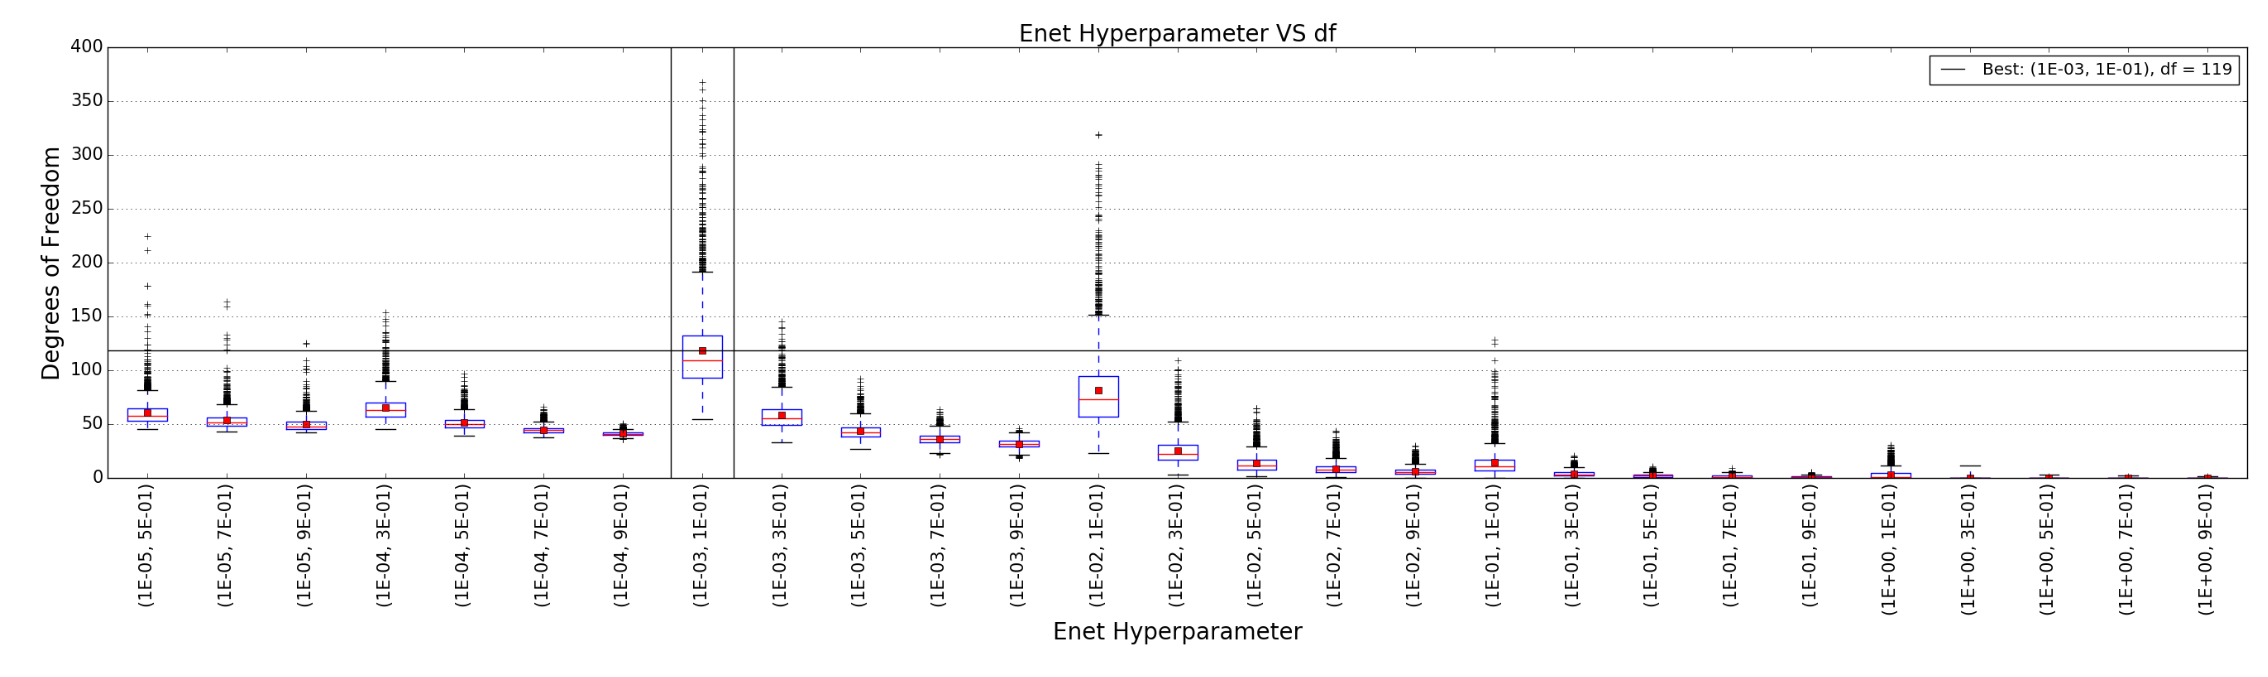

0mean-unnormalized_enet-2


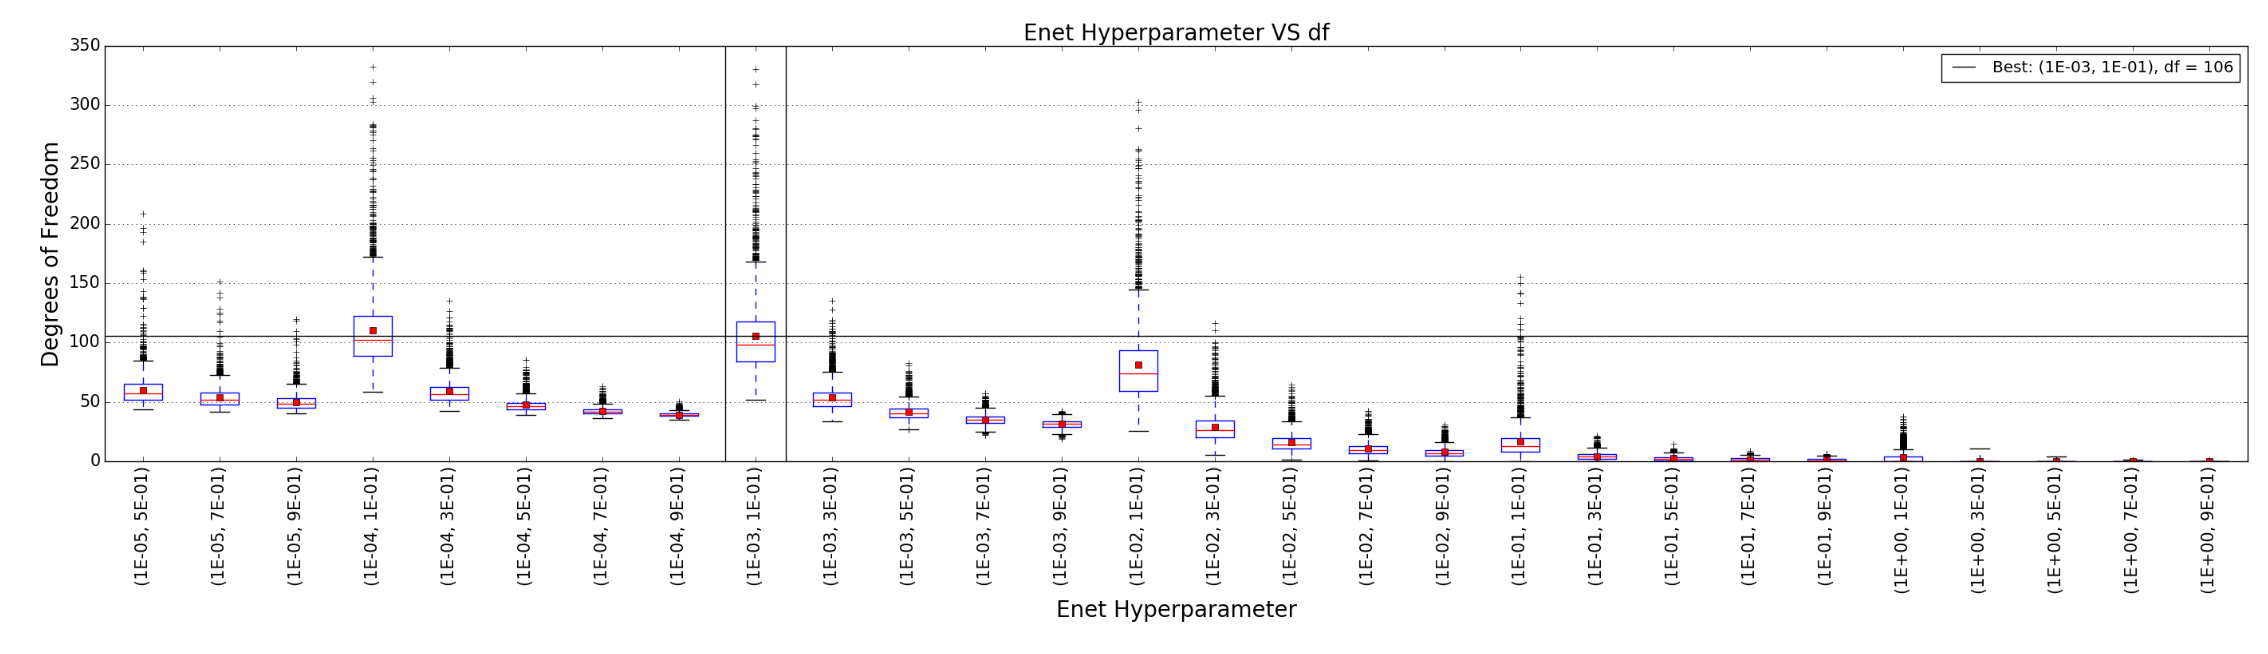

In [13]:
# Plot the hyper VS dof

print "Hyperparameters VS dof"

for name, hyperdofplot in zip(names, hyperdofplots):
    print name
    
    if "enet" in name:
        figsize = (40,30)
    else:
        figsize = (10,10)
    
    plt.figure(figsize=figsize)
    plt.imshow(hyperdofplot)
    plt.axis('off')
    plt.show()
    

In [14]:
cv_summary_dict = collections.OrderedDict()
cv_summary_dict["Name"] = names
cv_summary_dict["Hyperparameter"] = cp.hyperlist_to_labellist(hypers)
cv_summary_dict["r^2"] = [round(besthyperdf["r2_avg"], 2) for besthyperdf in besthyperdfs]
cv_summary_dict["df"] = [int(round(besthyperdf["df_avg"])) for besthyperdf in besthyperdfs]
cv_summary_df = pd.DataFrame(cv_summary_dict)

cv_summary_file = "analysis" + os.sep + run_type + "_cv-summary.csv"

print 'Writing to ', cv_summary_file
cv_summary_df.to_csv(cv_summary_file, index=False)


display(cv_summary_df)

Writing to  analysis/priority_cv-summary.csv


,Name,Hyperparameter,r^2,df
0,0mean-1var_enet-1,"(1E-03, 1E-01)",0.61,151
1,0mean-1var_enet-2,"(1E-01, 1E-01)",0.46,143
2,0mean-unnormalized_enet-1,"(1E-03, 1E-01)",0.54,119
3,0mean-unnormalized_enet-2,"(1E-03, 1E-01)",0.37,106


# Beta distributions

In [26]:
betaplot1files = [x for x in [folder + os.sep + "plots" + os.sep + "betas" + os.sep + "beta_abs_coef-1.png" for folder in folders]
                  if os.path.exists(x)]
betaplot2files = [x for x in [folder + os.sep + "plots" + os.sep + "betas" + os.sep + "beta_abs_coef-2.png" for folder in folders]
                  if os.path.exists(x)]
betaplot1s = [mpimg.imread(b) for b in betaplot1files]
betaplot2s = [mpimg.imread(b) for b in betaplot2files]



Coef 1 betas
run/prot2TPM-er-reps_0mean-1var_g-null_l-fdr-0.05_enet-1/plots/betas/beta_abs_coef-1.png


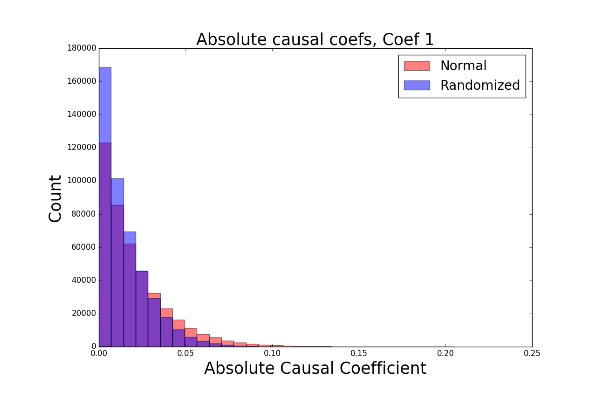

run/prot2TPM-er-reps_0mean-1var_g-null_l-fdr-0.05_enet-2/plots/betas/beta_abs_coef-1.png


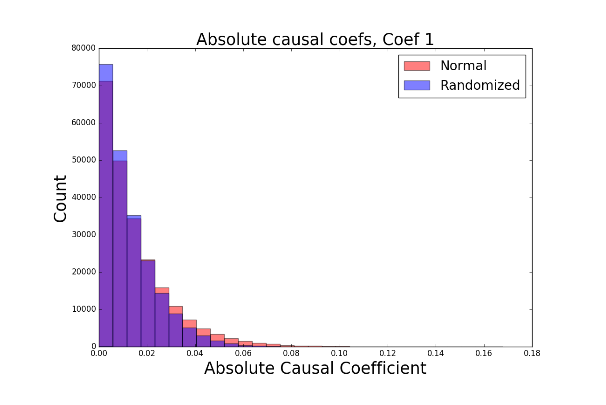

run/prot2TPM-er-reps_0mean-unnormalized_g-null_l-fdr-0.05_enet-1/plots/betas/beta_abs_coef-1.png


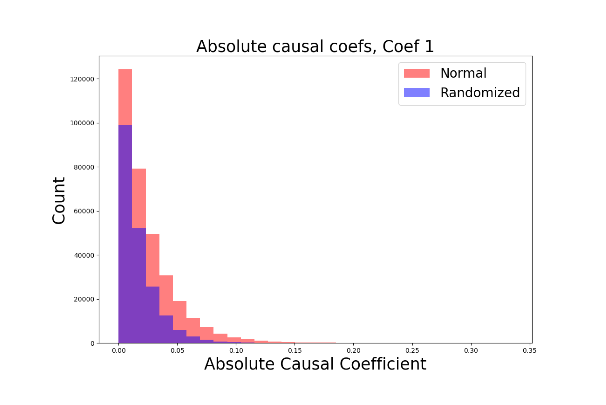

run/prot2TPM-er-reps_0mean-unnormalized_g-null_l-fdr-0.05_enet-2/plots/betas/beta_abs_coef-1.png


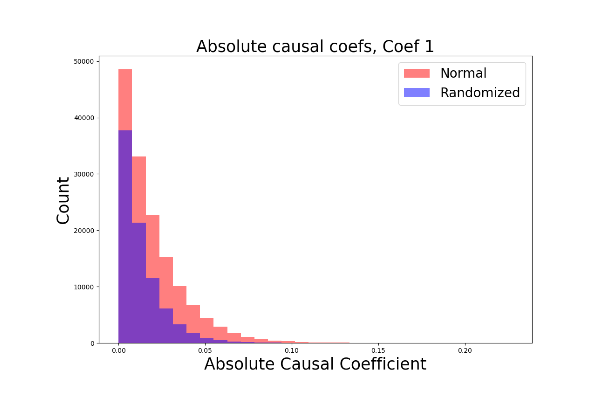

In [27]:
# Display coef 1 files

print "Coef 1 betas"
for betaplot1, betaplot1file in zip(betaplot1s, betaplot1files):
    plt.figure(figsize=(10,10))
    print betaplot1file
    plt.imshow(betaplot1)
    plt.axis('off')
    plt.show()

Coef 2 betas
run/prot2TPM-er-reps_0mean-1var_g-null_l-fdr-0.05_enet-2/plots/betas/beta_abs_coef-2.png


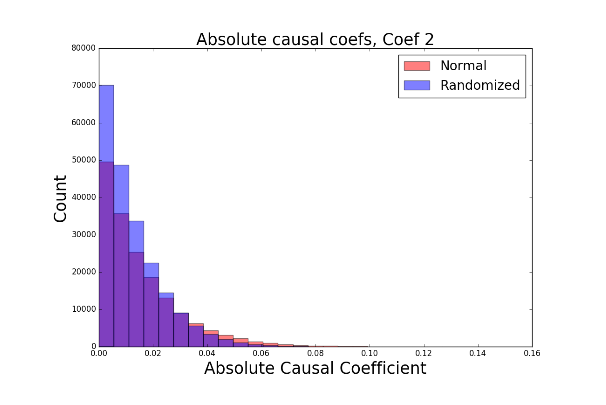

run/prot2TPM-er-reps_0mean-unnormalized_g-null_l-fdr-0.05_enet-2/plots/betas/beta_abs_coef-2.png


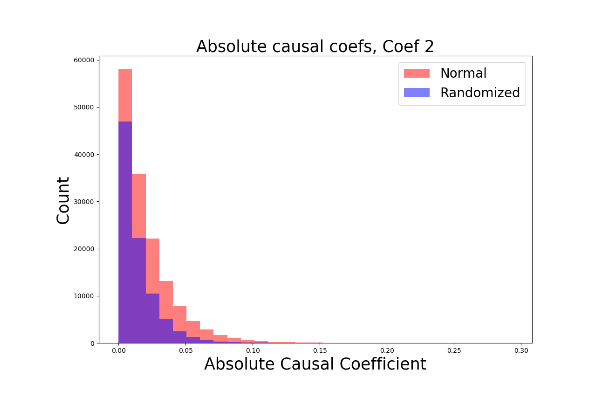

In [28]:
# Display coef 2 files

print "Coef 2 betas"
for betaplot2, betaplot2file in zip(betaplot2s, betaplot2files):
    plt.figure(figsize=(10,10))
    print betaplot2file
    plt.imshow(betaplot2)
    plt.axis('off')
    plt.show()